In [1]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ia2_project')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZVaIc7_d2UbXdolqFwAboCAl34UOyERP/ia2_project


# **General Libraries**

In [3]:
!pip install sentiment-analysis-spanish
!pip install tweet-preprocessor
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

     |████████████████████████████████| 30.0MB 101kB/s 


In [4]:
#@title Libraries

from sentiment_analysis_spanish import sentiment_analysis
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
import datetime
from textblob import TextBlob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections
import tweepy
import nltk
import re
from nltk.corpus import stopwords
import preprocessor as p
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# **Web Scrapping**

Explicación del web scrapping

In [ ]:
data1 = pd.read_csv('data/data_generator/tweets_covid_5236-2021-03-04.csv')
data2 = pd.read_csv('data/data_generator/tweets_covid_2241-2020-012-021.csv')
data3 = pd.read_csv('data/data_generator/tweets_covid_1083-2020-09-017.csv')
tweets_validation = pd.concat([data1,data2,data3])
tweets_validation.dropna(inplace=True)
tweets_validation.drop_duplicates(inplace=True)
tweets_validation.reset_index(drop=True, inplace=True)


In [ ]:
def cut_date(s):
  s = s[:10]
  return s

In [ ]:
tweets_validation["Fecha"] = tweets_validation["Fecha"].apply(cut_date)
date_format = "%Y/%m/%d"
tweets_validation["Fecha"] = pd.to_datetime(tweets_validation["Fecha"], format=date_format)
tweets_validation

,Nombre de usuario,Usuario,Fecha,Texto
0,Danesis,@DanesisArce,2021-03-04,La mejor vacuna contra el uribismo \n@CeDemocr...
1,Paula Ayala,@PaulaaAyala10,2021-03-04,Hoy me vacunaron contra el COVID. No dejo de p...
2,Alejandra Jiménez,@alejandrajc10,2021-03-04,Yo sí estoy de acuerdo con el señor de la ofic...
3,Julián Romero,@julianandres298,2021-03-04,Mis parcerxs docentes en Argentina ya están re...
4,FabianM,@MattoneFabian,2021-03-04,Che me jodes? Despues del choreo o Vacuna-Gate...
...,...,...,...,...
8508,Ells,@ellscms,2020-08-08,"Pregunta muy seria, ustedes se pondrían la vac..."
8509,J_Lozano.,@J_LozanoC,2020-08-08,Cuando llegue la vacuna a Colombia se imaginan...
8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,A pesar de haber sido los consentidos de la Na...
8511,Paradise.,@_DreamWorlds_,2020-08-08,¿Cuando va a llegar a Colombia la vacuna contr...


Since we're retrieving information from twitter (tweets) and these are text we need to make a clean up process before get into analysing our data. This process is called 'Natural Language Processing'.

![](https://drive.google.com/uc?export=view&id=1Wv5W1wvqjd6KtwjFUkHcYlL_VNNsyjOX)

After submitting your application you will get an email from Twitter wheter asking you for more detailed information or giving you access to their API.

Before get started, since we will be creating our own dataset to perform sentiment analysis on tweets from Spanish speakers, we will use a Python library called 'Tweepy' in order to retrieve the information. However, it is necessary to apply to a 'Twitter Developer Account' which is going to allow us to collect Twitter data.

Once you apply to the Twiiter Developer Account you'll be asked to give some information as follows:

![](https://drive.google.com/uc?export=view&id=1MkU6CS8R9s2A9EAnS4hzP850mzSPEmHj)

## Dataset para el generador de texto

In [ ]:
data_gobierno = pd.read_csv('data/data_classifier/tweets/tweets_covid_gobierno183.csv')
data_gobierno2 = pd.read_csv('data/data_classifier/tweets/tweets_covid_gobierno197.csv')
tweets_gobierno = pd.concat([data_gobierno,data_gobierno2])
tweets_gobierno.dropna(inplace=True)
tweets_gobierno.drop_duplicates(inplace=True)
tweets_gobierno.reset_index(drop=True, inplace=True)
tweets_gobierno["Hashtag"] = ""
tweets_gobierno


,Nombre de usuario,Usuario,Fecha,Texto,Hashtag
0,Supersalud,@Supersalud,2021-03-06T20:30:15.000Z,@Supersalud\n Fabio Aristizábal visitó el depa...,
1,MinSaludCol,@MinSaludCol,2021-03-06T20:30:00.000Z,#JuntosFrenteAlCovid Fueron muchos los hitos e...,
2,MinSaludCol,@MinSaludCol,2021-03-06T18:31:28.000Z,"En la concha acústica de Mitú, Vaupés, el mini...",
3,SecretaríaSaludCesar,@CesarSecSalud,2021-03-06T03:32:46.000Z,#ReporteDiariio reportamos 35 nuevos casos de ...,
4,Gobernación del Huila,@HuilaGob,2021-03-06T03:26:23.000Z,41 casos de Covid19 se confirmaron hoy para el...,
...,...,...,...,...,...
279,Presidencia Colombia,@infopresidencia,2021-03-03T19:42:01.000Z,Aunque ya inició la aplicación de vacunas #Seg...,
280,MinSaludCol,@MinSaludCol,2021-03-03T16:31:17.000Z,#Noticia \nColombia recibió 100.000 nuevas dos...,
281,MinSaludCol,@MinSaludCol,2021-03-03T14:59:20.000Z,Vacunarte contra la COVID-19 es una manera seg...,
282,Canal Institucional,@InstitucionalTV,2021-03-03T12:26:00.000Z,#SeñalDeLaMañana | El director del Departamen...,


In [ ]:
def extraer_hastag(s):
  parsed_tweet = p.parse(s)
  hashtag = parsed_tweet.hashtags
  return hashtag

In [ ]:
tweets_gobierno["Hashtag"] = tweets_gobierno["Texto"].apply(extraer_hastag)
hashtags = tweets_gobierno.Hashtag.values
tweets_gobierno["Hashtag"] = tweets_gobierno["Hashtag"].fillna(value="")
tweets_gobierno

,Nombre de usuario,Usuario,Fecha,Texto,Hashtag
0,Supersalud,@Supersalud,2021-03-06T20:30:15.000Z,@Supersalud\n Fabio Aristizábal visitó el depa...,[(57:64) => #Boyacá]
1,MinSaludCol,@MinSaludCol,2021-03-06T20:30:00.000Z,#JuntosFrenteAlCovid Fueron muchos los hitos e...,[(0:20) => #JuntosFrenteAlCovid]
2,MinSaludCol,@MinSaludCol,2021-03-06T18:31:28.000Z,"En la concha acústica de Mitú, Vaupés, el mini...",
3,SecretaríaSaludCesar,@CesarSecSalud,2021-03-06T03:32:46.000Z,#ReporteDiariio reportamos 35 nuevos casos de ...,[(0:15) => #ReporteDiariio]
4,Gobernación del Huila,@HuilaGob,2021-03-06T03:26:23.000Z,41 casos de Covid19 se confirmaron hoy para el...,
...,...,...,...,...,...
279,Presidencia Colombia,@infopresidencia,2021-03-03T19:42:01.000Z,Aunque ya inició la aplicación de vacunas #Seg...,[(42:60) => #SegurasYEfectivas]
280,MinSaludCol,@MinSaludCol,2021-03-03T16:31:17.000Z,#Noticia \nColombia recibió 100.000 nuevas dos...,[(0:8) => #Noticia]
281,MinSaludCol,@MinSaludCol,2021-03-03T14:59:20.000Z,Vacunarte contra la COVID-19 es una manera seg...,[(218:229) => #YoMeVacuno]
282,Canal Institucional,@InstitucionalTV,2021-03-03T12:26:00.000Z,#SeñalDeLaMañana | El director del Departamen...,"[(1:17) => #SeñalDeLaMañana, (346:362) => #Señ..."


In [ ]:
def hashtags(s):
  list_items = []
  for i in range(len(s)):
    list_items.append(s[i].match)
  return list_items

In [ ]:
tweets_gobierno["Hashtag"] = tweets_gobierno["Hashtag"].apply(hashtags)

In [ ]:
tweets_gobierno

,Nombre de usuario,Usuario,Fecha,Texto,Hashtag
0,Supersalud,@Supersalud,2021-03-06T20:30:15.000Z,@Supersalud\n Fabio Aristizábal visitó el depa...,[#Boyacá]
1,MinSaludCol,@MinSaludCol,2021-03-06T20:30:00.000Z,#JuntosFrenteAlCovid Fueron muchos los hitos e...,[#JuntosFrenteAlCovid]
2,MinSaludCol,@MinSaludCol,2021-03-06T18:31:28.000Z,"En la concha acústica de Mitú, Vaupés, el mini...",[]
3,SecretaríaSaludCesar,@CesarSecSalud,2021-03-06T03:32:46.000Z,#ReporteDiariio reportamos 35 nuevos casos de ...,[#ReporteDiariio]
4,Gobernación del Huila,@HuilaGob,2021-03-06T03:26:23.000Z,41 casos de Covid19 se confirmaron hoy para el...,[]
...,...,...,...,...,...
279,Presidencia Colombia,@infopresidencia,2021-03-03T19:42:01.000Z,Aunque ya inició la aplicación de vacunas #Seg...,[#SegurasYEfectivas]
280,MinSaludCol,@MinSaludCol,2021-03-03T16:31:17.000Z,#Noticia \nColombia recibió 100.000 nuevas dos...,[#Noticia]
281,MinSaludCol,@MinSaludCol,2021-03-03T14:59:20.000Z,Vacunarte contra la COVID-19 es una manera seg...,[#YoMeVacuno]
282,Canal Institucional,@InstitucionalTV,2021-03-03T12:26:00.000Z,#SeñalDeLaMañana | El director del Departamen...,"[#SeñalDeLaMañana, #SeñalDeLaMañana]"


In [ ]:
hashtags = tweets_gobierno.Hashtag.values
hashtags_list = []
for item in hashtags:
  for i in range(len(item)):
    hashtags_list.append(item[i])

In [ ]:
from collections import Counter

c = Counter(hashtags_list)
print(len(c), c)


101 Counter({'#COVID19': 21, '#SeñalDeLaMañana': 21, '#JuntosFrenteAlCovid': 20, '#CuidarnosYVacunarnos': 19, '#UnAñoSalvandoVidas': 16, '#PrevenciónYAcción': 15, '#Covid_19': 12, '#PrevenciónyAcción': 11, '#AlAire': 9, '#YoMeVacuno': 8, '#EnVivo': 7, '#Noticia': 6, '#SeguimientoALasVacunas': 6, '#AEstaHora': 5, '#EnMiTurnoYoMeVacuno': 4, '#AtlánticoConVida': 4, '#SegurasYEfectivas': 4, '#MiVacuna': 4, '#Boyacá': 3, '#ColombiaSeVacuna': 3, '#PrimeroLaVacuna': 3, '#Antioquia': 3, '#ReporteCOVID19': 3, '#MiAñoEnPandemiaFue': 3, '#LaVerdadDeLaVacuna': 3, '#EPS': 3, '#VacunaciónCovid19': 3, '#BogotáSeCuida': 3, '#CórdobaSeVacuna': 3, '#PrevenciónyAcciónPresidencia': 2, '#ReporteCovid': 2, '#Caldas': 2, '#ViceSalud': 2, '#YoMeVacuno0': 2, '#BogotáDeTuLado': 2, '#FacebookLive': 2, '#SaluData': 2, '#FBLive': 2, '#ReporteDiario': 2, '#BogotáSeCuidaSecretaría': 2, '#HuilaCrece': 2, '#UnAñoDePandemia': 2, '#Hoy': 2, '#BoletínCOVID19': 2, '#ReporteDiariio': 1, '#Guainía': 1, '#PrimeroLaVida': 1, 

In [ ]:
usuarios = tweets_gobierno["Usuario"].groupby(tweets_gobierno["Usuario"]).count().sort_values(ascending=False)
usuarios

Usuario
@MinSaludCol        36
@GobAntioquia       33
@infopresidencia    32
@InstitucionalTV    25
@Bogota             21
@Supersalud         15
@SectorSalud        13
@SaludAntioquia     10
@GobdeSantander      9
@HuilaGob            9
@GobMeta             8
@saluddecaldas       7
@ClaudiaLopez        5
@LAGUAJIRAGOB        5
@secsaludvalle       4
@MagdalenaGober      4
@nicolasgarciab      3
@CesarSecSalud       3
@ClaraLuzRoldan      3
@CordobaSalud        3
@Gobatlantico        3
@SSaludBoyaca        3
@MAguilarHurtado     3
@GobDeBolivar        2
@GobSucre            2
@CundinamarcaGob     2
@orlandobenitezm     2
@GobCordoba_         2
@elsanoguerabaq      2
@RamiroBarraganA     2
@OPSOMS_Col          2
@INSColombia         2
@VictorTamayoV       1
@Gob_Risaralda       1
@GobBoyaca           1
@mluciaramirez       1
@Goberamazonas       1
@gobernavaupes       1
@saludcauca          1
@NemesioRoys         1
@IvanDuque           1
Name: Usuario, dtype: int64

In [ ]:
usuarios = tweets_gobierno["Usuario"].groupby(tweets_gobierno["Usuario"]).count().sort_values(ascending=False)
usuario = usuarios.index.values
for i in range(11):
  print(usuario[i])

@MinSaludCol
@GobAntioquia
@infopresidencia
@InstitucionalTV
@Bogota
@Supersalud
@SectorSalud
@SaludAntioquia
@GobdeSantander
@HuilaGob
@GobMeta


## Datos para el clasificador

### #YoMeVacuno

In [ ]:
data_positiva = pd.read_csv('data/data_classifier/tweets/tweets_covid_positivo5054.csv')
data_positiva.dropna(inplace=True)
data_positiva.drop_duplicates(inplace=True)
data_positiva.reset_index(drop=True, inplace=True)

In [ ]:
fechas = data_positiva.Fecha
fechas

0       2021-03-06T17:27:16.000Z
1       2021-03-06T17:22:27.000Z
2       2021-03-06T17:13:20.000Z
3       2021-03-06T17:00:58.000Z
4       2021-03-06T17:00:23.000Z
                  ...           
5032    2021-01-27T16:53:12.000Z
5033    2021-01-27T16:52:56.000Z
5034    2021-01-27T16:47:44.000Z
5035    2021-01-27T16:42:38.000Z
5036    2021-01-27T16:41:29.000Z
Name: Fecha, Length: 5037, dtype: object

In [ ]:
for i in range(len(fechas)):
  fechas[i] = fechas[i][:10]

data_positiva["Fecha"] = fechas

In [ ]:
date_format = "%Y/%m/%d"
data_positiva["Fecha"] = pd.to_datetime(data_positiva["Fecha"], format=date_format)
data_positiva["Sentimiento"] = 1
data_positiva

,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,Aurora Fuentes,@paysandusiempre,2021-03-06,No dejen de mirar número de casos positivos d...,1
1,majo,@majoattacks,2021-03-06,#YoMeVacuno y todos los adultos mayores de mi ...,1
2,#YoApruebo,@xapahernandez,2021-03-06,"Hasta el Dalai Lama se vacunó, y todavía algun...",1
3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,#YoMeVacuno contra el terruqueo \n#YoMeVacuno ...,1
4,Jose Ragas,@joseragas,2021-03-06,Lo que hace Willax no es libertad de expresión...,1
...,...,...,...,...,...
5032,Isidora Elvira Molina,@PolymirII,2021-01-27,"#YoMeVacuno \nLa viruela, una enfermedad con u...",1
5033,𝓟𝓲𝓪,@joylaferte,2021-01-27,#YoMeVacuno no soy weona,1
5034,Britt Wallberg Núñez,@bwallbergn,2021-01-27,Soy grupo de riesgo y estoy extremando cuidado...,1
5035,dinosaurio,@paradoximon,2021-01-27,Hay cada uno que toma cocaína cortada con cual...,1


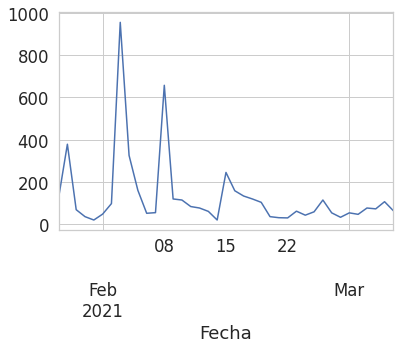

In [ ]:
data_positiva_fechas = data_positiva["Fecha"].groupby(data_positiva["Fecha"]).count()
data_positiva_fechas.sort_index
data_positiva_fechas.plot()

In [ ]:
data_positiva_fechas.sort_values(ascending=False)

Fecha
2021-02-03    957
2021-02-08    658
2021-01-28    378
2021-02-04    325
2021-02-15    244
2021-02-05    159
2021-02-16    157
2021-02-17    132
2021-01-27    123
2021-02-18    118
2021-02-09    118
2021-02-10    113
2021-02-26    113
2021-03-05    105
2021-02-19    102
2021-02-02     96
2021-02-11     82
2021-02-12     75
2021-03-03     75
2021-03-04     71
2021-01-29     67
2021-03-06     62
2021-02-23     60
2021-02-13     59
2021-02-25     57
2021-02-07     53
2021-02-27     52
2021-03-01     52
2021-02-06     50
2021-02-01     46
2021-03-02     45
2021-02-24     41
2021-02-20     34
2021-01-30     34
2021-02-28     31
2021-02-21     29
2021-02-22     28
2021-02-14     18
2021-01-31     18
Name: Fecha, dtype: int64

In [ ]:
data_positiva.to_csv('data/data_classifier/tweets_positivos.csv')

### #YoNoMeVacuno

In [ ]:
data1= pd.read_csv('data/data_classifier/tweets/tweets_covid_negativo5085.csv')
data2 = pd.read_csv('data/data_classifier/tweets/tweets_covid_negativo3193.csv')
data_negativa = pd.concat([data1,data2])
data_negativa.dropna(inplace=True)
data_negativa.drop_duplicates(inplace=True)
data_negativa.reset_index(drop=True, inplace=True)
data_negativa.tail()

,Nombre de usuario,Usuario,Fecha,Texto
8194,Migue,@mikes_83,2020-11-03T01:16:45.000Z,#YoNoMeVacuno Mientras los macristas y anticua...
8195,mendieta\nfirpo,@mfirpo2021,2020-11-03T01:16:38.000Z,#YoNoMeVacuno \nestá claro que el inútil de \n...
8196,Mirta\nTod\ns,@mirtanicosia,2020-11-03T01:16:36.000Z,La mejor noticia! Alberto y Cristina demostran...
8197,Sergio_jl,@Sergiojl6,2020-11-03T01:16:36.000Z,#YoNoMeVacuno\nLos Rusos se saltearon la Fase ...
8198,TheLastDragon_98,@Albiceleste98,2020-11-03T01:16:33.000Z,"#YoNoMeVacuno ah pero, la cuarentena no sirve,..."


In [ ]:
fechas = data_negativa.Fecha
fechas

0       2021-03-06T02:58:42.000Z
1       2021-03-06T02:45:30.000Z
2       2021-03-06T01:03:54.000Z
3       2021-03-06T01:03:05.000Z
4       2021-03-05T21:59:34.000Z
                  ...           
8194    2020-11-03T01:16:45.000Z
8195    2020-11-03T01:16:38.000Z
8196    2020-11-03T01:16:36.000Z
8197    2020-11-03T01:16:36.000Z
8198    2020-11-03T01:16:33.000Z
Name: Fecha, Length: 8199, dtype: object

In [ ]:
for i in range(len(fechas)):
  fechas[i] = fechas[i][:10]

data_negativa["Fecha"] = fechas

In [ ]:
date_format = "%Y/%m/%d"
data_negativa["Fecha"] = pd.to_datetime(data_negativa["Fecha"], format=date_format)
data_negativa["Sentimiento"] = 0
data_negativa

,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,judi,@Judi_Arenaluza,2021-03-06,Vengo de mi cardio confieso que me topé con un...,0
1,Aerotiburon,@FREEEFALLLL,2021-03-06,#YoNoMeVacuno 11% y 33% de eficacia?..es ciert...,0
2,@LordDarthVader,@LordDarthVader,2021-03-06,Hoy es viernes y mi #YoNoMeVacuno lo sabe,0
3,Lord Vader,@mantisreligioso,2021-03-06,Tengo muy en claro que #YoNoMeVacuno,0
4,El Melena,@melelaborde,2021-03-05,"No importa la Vacuna , de que laboratorio , el...",0
...,...,...,...,...,...
8194,Migue,@mikes_83,2020-11-03,#YoNoMeVacuno Mientras los macristas y anticua...,0
8195,mendieta\nfirpo,@mfirpo2021,2020-11-03,#YoNoMeVacuno \nestá claro que el inútil de \n...,0
8196,Mirta\nTod\ns,@mirtanicosia,2020-11-03,La mejor noticia! Alberto y Cristina demostran...,0
8197,Sergio_jl,@Sergiojl6,2020-11-03,#YoNoMeVacuno\nLos Rusos se saltearon la Fase ...,0


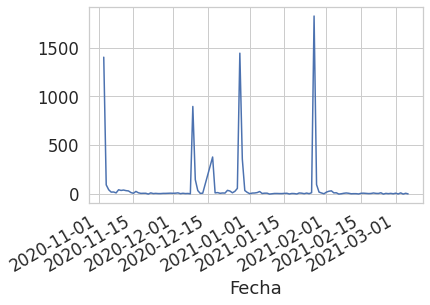

In [ ]:
fechas_negativas = data_negativa["Fecha"].groupby(data_negativa["Fecha"]).count()
fechas_negativas.sort_index
fechas_negativas.plot()

In [ ]:
fechas_negativas.sort_values(ascending=False)

Fecha
2021-01-27    1823
2020-12-28    1443
2020-11-03    1402
2020-12-09     898
2020-12-17     381
              ... 
2020-11-21       2
2021-02-06       2
2021-01-09       2
2021-03-04       2
2021-02-24       2
Name: Fecha, Length: 121, dtype: int64

In [ ]:
df_validation = pd.concat([data_negativa[(data_negativa["Fecha"]=='2021-01-27')],data_negativa[(data_negativa["Fecha"]=='2020-12-28')], data_negativa[(data_negativa["Fecha"]=='2020-11-03')],data_negativa[(data_negativa["Fecha"]=='2020-12-09')],]) 
#df_validation = df_validation[df_validation["Fecha"]=='2020-12-28']
#df_validation = df_validation[df_validation["Fecha"]=='2020-11-03']
#df_validation = df_validation[df_validation["Fecha"]=='2020-12-09']
df_validation.dropna(inplace=True)
df_validation.drop_duplicates(inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_validation = df_validation.drop('Sentimiento',1)
df_validation



,Nombre de usuario,Usuario,Fecha,Texto
0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,Las vacunas matan gente y no lo están diciendo...
1,Némesis,@MaryBol95533136,2021-01-27,Aplicadores anales: La nueva forma del régime...
2,S A N T I,@diluidoenagua,2021-01-27,Me encanta que haya tanta gente diciendo #YoNo...
3,moon:),@luuunaaaaaaaae,2021-01-27,"Mejor, así los que nos queremos vacunar lo hac..."
4,Carlos.,@Carloscdc06,2021-01-27,¿#YoNoMeVacuno? \n\nComan mierda hptas.
...,...,...,...,...
5561,🅜🅡.🅝🅞🅑🅞🅓🅨,@Mr_N00b00dy,2020-12-09,"El hashtag #YoMeVacunare es trending, pero #Yo..."
5562,Lord Vader,@mantisreligioso,2020-12-09,LOS POLÍTICOS SON NUESTROS ENEMIGOS. #YoNoMeVa...
5563,Lord Vader,@mantisreligioso,2020-12-09,NO VACUNARSE. #YoNoMeVacuno
5564,@LordDarthVader,@LordDarthVader,2020-12-09,LOS POLÍTICOS SON NUESTROS ENEMIGOS. #YoNoMeVa...


In [ ]:
tweets_validation2 = pd.concat([df_validation,tweets_validation])
df_validation.dropna(inplace=True)
df_validation.drop_duplicates(inplace=True)
df_validation.reset_index(drop=True, inplace=True)
tweets_validation2.to_csv('data/data_classifier/tweets_validation.csv')
tweets_validation2

,Nombre de usuario,Usuario,Fecha,Texto
0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,Las vacunas matan gente y no lo están diciendo...
1,Némesis,@MaryBol95533136,2021-01-27,Aplicadores anales: La nueva forma del régime...
2,S A N T I,@diluidoenagua,2021-01-27,Me encanta que haya tanta gente diciendo #YoNo...
3,moon:),@luuunaaaaaaaae,2021-01-27,"Mejor, así los que nos queremos vacunar lo hac..."
4,Carlos.,@Carloscdc06,2021-01-27,¿#YoNoMeVacuno? \n\nComan mierda hptas.
...,...,...,...,...
8508,Ells,@ellscms,2020-08-08,"Pregunta muy seria, ustedes se pondrían la vac..."
8509,J_Lozano.,@J_LozanoC,2020-08-08,Cuando llegue la vacuna a Colombia se imaginan...
8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,A pesar de haber sido los consentidos de la Na...
8511,Paradise.,@_DreamWorlds_,2020-08-08,¿Cuando va a llegar a Colombia la vacuna contr...


In [ ]:
df_negativos = data_negativa[data_negativa["Fecha"]!='2021-01-27'] 
df_negativos = df_negativos[df_negativos["Fecha"]!='2020-12-28']
df_negativos = df_negativos[df_negativos["Fecha"]!='2020-11-03']
df_negativos = df_negativos[df_negativos["Fecha"]!='2020-12-09']
df_negativos.dropna(inplace=True)
df_negativos.drop_duplicates(inplace=True)
df_negativos.reset_index(drop=True, inplace=True)
df_negativos

,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,judi,@Judi_Arenaluza,2021-03-06,Vengo de mi cardio confieso que me topé con un...,0
1,Aerotiburon,@FREEEFALLLL,2021-03-06,#YoNoMeVacuno 11% y 33% de eficacia?..es ciert...,0
2,@LordDarthVader,@LordDarthVader,2021-03-06,Hoy es viernes y mi #YoNoMeVacuno lo sabe,0
3,Lord Vader,@mantisreligioso,2021-03-06,Tengo muy en claro que #YoNoMeVacuno,0
4,El Melena,@melelaborde,2021-03-05,"No importa la Vacuna , de que laboratorio , el...",0
...,...,...,...,...,...
2622,lid,@ldutari,2020-11-04,#YoNoMeVacuno ni loca aunque sea obligatoria? ...,0
2623,Juan Manuel,@majud03,2020-11-04,#YoNoMeVacuno\n#YoNoMeVacuno ni mi familia... ...,0
2624,Florencia Balcarce,@beappatt,2020-11-04,La vacuna del Swine Flu en 1976 ocasionó más m...,0
2625,"No, Korruptos",@carlita_River19,2020-11-04,#YoMeVacuno Me causa gracia xq todo es grieta ...,0


In [ ]:
df_negativos.to_csv('data/data_classifier/tweets_negativos.csv')

## Dataset unido

In [ ]:
tweets_negativos = pd.read_csv('data/data_classifier/tweets_negativos.csv')
tweets_positivos = pd.read_csv('data/data_classifier/tweets_positivos.csv')
tweets = pd.concat([tweets_positivos, tweets_negativos])
tweets.dropna(inplace=True)
tweets.drop_duplicates(inplace=True)
tweets.reset_index(drop=True, inplace=True)

In [ ]:
tweets.to_csv('data/data_classifier/tweets.csv')

# **NATURAL LANGUAGE PROCESSING (NLP)**

Normally any NLP task involves the following text cleaning techniques:


*   Removal of HTML tags (e.g., '< br>').
*   Removal of punctuations and special characters (e.g., '\t', '\n').
*   Removal of 'stopwords' which do not give us much information (e.g., 'is', 'are', 'we').
*   Stemming / Lemmatization to bring multiple forms of a same word back into their common root (e.g., playing, plays, played into 'play').
*   Word vectorization or Word Embeddings which is the process of converting words into numbers.
*   Fit the data to the ML model.

## **Limpiar tweets para el modelo clasificador**

First, let's make a copy of the tweets to make the text processing.

In [ ]:
tweets = pd.read_csv('data/data_classifier/tweets.csv')
tweets_copia =  tweets['Texto'].values
tweets_copia

array([' No dejen de mirar número de casos positivos de ayer y número  en CTI.\n992 Y 80\n\n#YoMeQuedoEnCasa \n#YoMeVacuno',
       '#YoMeVacuno y todos los adultos mayores de mi familia también lo harán \n \n\nConversen con sus abuelitos. Nadie como los nietos para tratarlos con cariño, informando y aprendiendo juntos.',
       'Hasta el Dalai Lama se vacunó, y todavía algunos le dan color #YoMeVacuno',
       ...,
       'La vacuna del Swine Flu en 1976 ocasionó más muertes que la enfermedad que pretendía prevenir. Con esta rusa que traen en diciembre podría pasarnos lo mismo. Según los rusos estaría probada recién en marzo del 2021 #YoNoMeVacuno',
       '#YoMeVacuno Me causa gracia xq todo es grieta ahora la vacuna lo único divertido son los memes , lo otro es cansador.\nPD : #YoNoMeVacuno ',
       'Se meten cada cosa en el cuerpo y ahora salen con el #YoNoMeVacuno. Lolamento pero si el vodkanita no me mató, yo ya estoy.'],
      dtype=object)

### **Removing Punctuations and Special Characters**

As we can see, people use to attach links to their tweets as well as pound signs or hashtags ('#') and at signs ('@'). So, let's clean that up using 'Regular Expressions'.

In [ ]:
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ñ", "n"),
        (",",""),
        (".",""),
        (";",""),
        ("¿",""),
        ("?","")
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [ ]:
for i in range(len(tweets_copia)):
  tweets_copia[i] = normalize(tweets_copia[i])
  tweets_copia[i] = tweets_copia[i].lower()
  p.set_options(p.OPT.URL, p.OPT.HASHTAG, p.OPT.EMOJI)
  tweets_copia[i] = p.clean(tweets_copia[i])

tweets_copia

array(['no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80',
       'y todos los adultos mayores de mi familia tambien lo haran conversen con sus abuelitos nadie como los nietos para tratarlos con carino informando y aprendiendo juntos',
       'hasta el dalai lama se vacuno y todavia algunos le dan color',
       ...,
       'la vacuna del swine flu en 1976 ocasiono mas muertes que la enfermedad que pretendia prevenir con esta rusa que traen en diciembre podria pasarnos lo mismo segun los rusos estaria probada recien en marzo del 2021',
       'me causa gracia xq todo es grieta ahora la vacuna lo unico divertido son los memes lo otro es cansador pd :',
       'se meten cada cosa en el cuerpo y ahora salen con el lolamento pero si el vodkanita no me mato yo ya estoy'],
      dtype=object)

In [ ]:
#@title **Cleanse Functions**

# Removes links and @ signs
def cleanText(txt):
  return re.sub('([^0-9A-Za-zñÑáéíóúÁÉÍÓÚ \t])|(\w+:\/\/\S+)', '', txt)

# Removes Punctuation including # signs and emojis
# def remove_punctuation(txt):
#   return re.sub(r'[^\w\s]', ' ', txt)

# Removes extra spaces
def remove_extra_spaces(txt):
  return re.sub(' +', ' ', txt)

In [ ]:
tweets_copia = np.array([cleanText(tweet) for tweet in tweets_copia])
tweets_copia[:20]

array(['no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80',
       'y todos los adultos mayores de mi familia tambien lo haran conversen con sus abuelitos nadie como los nietos para tratarlos con carino informando y aprendiendo juntos',
       'hasta el dalai lama se vacuno y todavia algunos le dan color',
       'contra el terruqueo contra la desinformacion de willaxtv contra el periodismo letrinoso de ortiz',
       'lo que hace willax no es libertad de expresion es una campana deliberada de desinformacion con el proposito de desestabilizar al gobierno sabotear la campana de vacunacion y poner en riesgo la salud de compatriotas para obtener beneficios politicos y economicos',
       'me agende el martes recibo la primer dosis',
       'ya esta hecho  juntos acabaremos con el',
       'muy bien ministra vbermudezv pcmperu muy clara y cumpliendo con defender el derecho a la vacunacion y a la informacion basada en la evidencia',
       'supera hoy los 4 millon

Since Python is case sensitive we're going to set everything to lowercase so that we will not have repeated words.

Now let's print a tweet now that we've cleaned the text.

In [ ]:
tweets["Texto"] = tweets_copia

In [ ]:
tweets.to_csv('data/data_classifier/tweets_NOLEMMA.csv')
tweets

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,no dejen de mirar numero de casos positivos de...,1
1,1,1,majo,@majoattacks,2021-03-06,y todos los adultos mayores de mi familia tamb...,1
2,2,2,#YoApruebo,@xapahernandez,2021-03-06,hasta el dalai lama se vacuno y todavia alguno...,1
3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,contra el terruqueo contra la desinformacion d...,1
4,4,4,Jose Ragas,@joseragas,2021-03-06,lo que hace willax no es libertad de expresion...,1
...,...,...,...,...,...,...,...
7659,7659,2622,lid,@ldutari,2020-11-04,ni loca aunque sea obligatoria y ni digan que ...,0
7660,7660,2623,Juan Manuel,@majud03,2020-11-04,ni mi familia metanse la vacuna bien en el,0
7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,la vacuna del swine flu en 1976 ocasiono mas m...,0
7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,me causa gracia xq todo es grieta ahora la vac...,0


### Split data

In order to do a more detailed analysis, we're going to plot the words frequency in all our tweets as we're doing more NLP tasks.

To achieve this, first we need to split every single tweet and store them in a new variable.

In [ ]:
words_in_tweet = [tweet.split() for tweet in tweets_copia]
words_in_tweet[0]

['no',
 'dejen',
 'de',
 'mirar',
 'numero',
 'de',
 'casos',
 'positivos',
 'de',
 'ayer',
 'y',
 'numero',
 'en',
 'cti',
 '992',
 'y',
 '80']

Now using 'itertools' and 'collections' modules we can group all the words in the tweets and count them.

In [ ]:
# List of all words across tweets
all_words = list(itertools.chain(*words_in_tweet))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15) # Print 15 most common words

[('de', 7642),
 ('que', 6492),
 ('la', 6268),
 ('y', 4499),
 ('a', 4429),
 ('el', 3687),
 ('no', 3380),
 ('en', 3075),
 ('los', 2603),
 ('se', 2195),
 ('por', 1987),
 ('es', 1836),
 ('con', 1823),
 ('me', 1713),
 ('vacuna', 1643)]

Let's now create a dataset with these values and do a bar plot so that we can see a better representation of the data.

In [ ]:
words_count = pd.DataFrame(counts.most_common(15),
                             columns=['words', 'count'])

words_count.head()

,words,count
0,de,7642
1,que,6492
2,la,6268
3,y,4499
4,a,4429


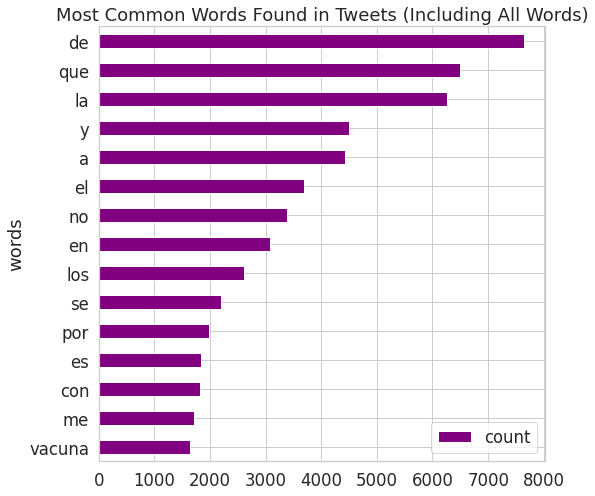

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets (Including All Words)")

plt.show()

### **Stopwords Removal**

We can see from the bar plot that the words with the highest frequency are not relevant words since don't give us any meaningful information. These are called 'stop words' and that's why we're going to remove them.

'nltk' package give us a list of stop words that we'll use to remove these empty words in our tweets.

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) # Set the language to Spanish

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's see some of these words:

In [ ]:
# View a few words from the set
list(stop_words)[0:20]

['otras',
 'ni',
 'estés',
 'siente',
 'fui',
 'somos',
 'había',
 'tú',
 'estarás',
 'habré',
 'tuvieras',
 'fuimos',
 'habrás',
 'mío',
 'sentidos',
 'otra',
 'sería',
 'suyas',
 'tendré',
 'de']

As we can see, the nltk package offer us a Spanish set of words. However, they're clearly in Spanish from Spain, this could lead us to a less efficient stop words removal process.

Now let's print again a tweet before removing stopwords ir order to do a comparison after the process.

In [ ]:
words_in_tweet[0]

['no',
 'dejen',
 'de',
 'mirar',
 'numero',
 'de',
 'casos',
 'positivos',
 'de',
 'ayer',
 'y',
 'numero',
 'en',
 'cti',
 '992',
 'y',
 '80']

In [ ]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['dejen',
 'mirar',
 'numero',
 'casos',
 'positivos',
 'ayer',
 'numero',
 'cti',
 '992',
 '80']

Once we've remove the stopwords it is clear that the amount of words are considerably lower. This is going to help us doing a more meaningful and efficiency analysis. Now, let's count the words again and plot a frequency barplot.

In [ ]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('vacuna', 1643),
 ('si', 1196),
 ('vacunas', 980),
 ('mas', 844),
 ('vacunacion', 651),
 ('hoy', 584),
 ('vacunarse', 515),
 ('dosis', 499),
 ('q', 487),
 ('vacunar', 411),
 ('gente', 384),
 ('personas', 362),
 ('dia', 357),
 ('salud', 352),
 ('ser', 350)]

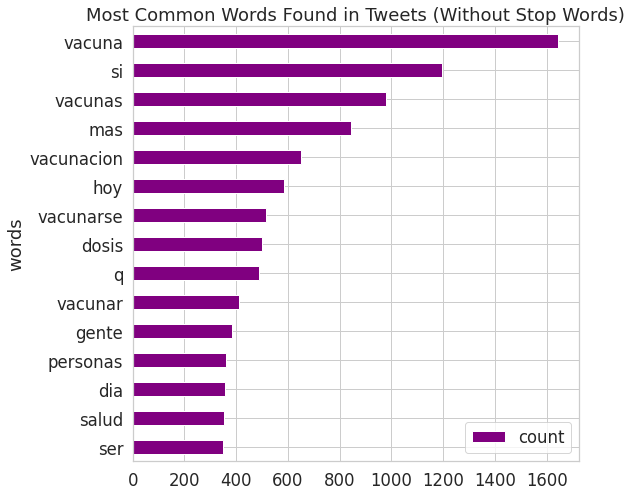

In [ ]:
words_count_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
words_count_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets (Without Stop Words)")

plt.show()

So now the highest frequency words seem to be 'more relevant' words than the one with the stop words.

### **Stemming / Lemmatization**

Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word. 

Since most of the packages that exist for NLP tasks are focused on English, it may be hard to achieve tasks such as stemming or lemmatization. However, there's a package called 'Stanza' that give us tools to create NLP models in many languages.

We are going to use **Lemmatization** so that you can see how it works.

In [ ]:
pip install stanza

In [ ]:
import stanza
stanza.download('es', package='ancora', processors='tokenize,mwt,pos,lemma', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,mwt,pos,lemma', lang='es', use_gpu=True)

2021-03-08 17:48:27 INFO: Downloading these customized packages for language: es (Spanish)...
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| pretrain  | ancora  |

2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/tokenize/ancora.pt.
2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/mwt/ancora.pt.
2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/pos/ancora.pt.
2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/lemma/ancora.pt.
2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/pretrain/ancora.pt.
2021-03-08 17:48:27 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-03-08 17:48:27 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-03-08 17:

In [ ]:
def join_string(list_string): 
  
    # Join the string based on '-' delimiter 
    string = ' '.join(list_string) 
      
    return string 

In [ ]:
rejoined_tweets =  [' '.join(tweet) for tweet in tweets_nsw]
rejoined_tweets[6]
tweets["Texto"] = rejoined_tweets
tweets
tweets.to_csv('data/data_classifier/tweetsSINSTOPWORDS.csv')

In [ ]:
processed_tweets = [stNLP(tweet) for tweet in rejoined_tweets]

In [ ]:
lemmatized_tweets = []
for t in processed_tweets:
  lemmatized_tweets.append([word.lemma for sent in t.sentences for word in sent.words])

In [ ]:
lemmatized_tweets[6]

['hecho', 'junto', 'acabar']

In [ ]:
tweets_final =  [' '.join(tweet) for tweet in lemmatized_tweets]
tweets_final[6]

'hecho junto acabar'

In [ ]:
tweets["Texto"] = tweets_final
tweets

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,dejar mirar numero caso positivo ayer numero c...,1
1,1,1,majo,@majoattacks,2021-03-06,adulto mayor familia tambien hacer conversar a...,1
2,2,2,#YoApruebo,@xapahernandez,2021-03-06,dalai lama vacuno todavia dar color,1
3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,terruqueo desinformacion willaxtv periodismo l...,1
4,4,4,Jose Ragas,@joseragas,2021-03-06,hacer willax libertad expresion campana delibe...,1
...,...,...,...,...,...,...,...
7659,7659,2622,lid,@ldutari,2020-11-04,loco aunque obligatorio decir gratis pagar,0
7660,7660,2623,Juan Manuel,@majud03,2020-11-04,familia metansar vacuna bien,0
7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,vacuna swine flu 1976 ocasionar mas muerte enf...,0
7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,causa gracia xq grieta ahora vacuna unico dive...,0


In [ ]:
tweets.to_csv('data/data_classifier/tweetsCONLEMMA.csv')

## **Limpiar tweets para la validación del modelo clasificador**

First, let's make a copy of the tweets to make the text processing.

In [ ]:
tweets = pd.read_csv('data/data_classifier/tweets_validation.csv')
tweets_copia =  tweets['Texto'].values
tweets_copia

array(['Las vacunas matan gente y no lo están diciendo #YoNoMeVacuno',
       ' Aplicadores anales: La nueva forma del régimen chino para someter a su gente a la detección del virus PCCh\nUna nueva forma de tomar el test,  esta vez por el recto.\n\nExigimos que se lo claven primero a la izquierda comunista. #Covid\n#YoNoMeVacuno',
       'Me encanta que haya tanta gente diciendo #YoNoMeVacuno así para los que si queremos nos va a llegar más rápido',
       ...,
       'A pesar de haber sido los consentidos de la Nación, hoy Colombia produce menos carne vacuna que en 1990. A pesar de usar más área para ese fin, tan improductivos son que Uruguay tiene con 1/6 de nuestro tamaño casi la misma producción.',
       '¿Cuando va a llegar a Colombia la vacuna contra el Covid?Octubre\n0 %\nNoviembre\n12,5 %\nDiciembre\n6,3 %\n2021\n81,3 %\n16 votos\n·\nResultados finales',
       'Pues no se pero lo que entendí es que la vacuna en Colombia será para nuestros adultos mayores pero seremos parte de

### **Removing Punctuations and Special Characters**

As we can see, people use to attach links to their tweets as well as pound signs or hashtags ('#') and at signs ('@'). So, let's clean that up using 'Regular Expressions'.

In [ ]:
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ñ", "n"),
        (",",""),
        (".",""),
        (";",""),
        ("¿",""),
        ("?","")
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [ ]:
for i in range(len(tweets_copia)):
  tweets_copia[i] = normalize(tweets_copia[i])
  tweets_copia[i] = tweets_copia[i].lower()
  p.set_options(p.OPT.URL, p.OPT.HASHTAG, p.OPT.EMOJI, p.OPT.MENTION)
  tweets_copia[i] = p.clean(tweets_copia[i])

tweets_copia

array(['las vacunas matan gente y no lo estan diciendo',
       'aplicadores anales: la nueva forma del regimen chino para someter a su gente a la deteccion del virus pcch una nueva forma de tomar el test esta vez por el recto exigimos que se lo claven primero a la izquierda comunista',
       'me encanta que haya tanta gente diciendo asi para los que si queremos nos va a llegar mas rapido',
       ...,
       'a pesar de haber sido los consentidos de la nacion hoy colombia produce menos carne vacuna que en 1990 a pesar de usar mas area para ese fin tan improductivos son que uruguay tiene con 1/6 de nuestro tamano casi la misma produccion',
       'cuando va a llegar a colombia la vacuna contra el covidoctubre 0 % noviembre 125 % diciembre 63 % 2021 813 % 16 votos resultados finales',
       'pues no se pero lo que entendi es que la vacuna en colombia sera para nuestros adultos mayores pero seremos parte de la fase experimental quieren cogerlos de conejillo de indias no hay derecho'],


In [ ]:
#@title **Cleanse Functions**

# Removes links and @ signs
def cleanText(txt):
  return re.sub('([^0-9A-Za-zñÑáéíóúÁÉÍÓÚ \t])|(\w+:\/\/\S+)', '', txt)

# Removes Punctuation including # signs and emojis
# def remove_punctuation(txt):
#   return re.sub(r'[^\w\s]', ' ', txt)

# Removes extra spaces
def remove_extra_spaces(txt):
  return re.sub(' +', ' ', txt)

In [ ]:
tweets_copia = np.array([cleanText(tweet) for tweet in tweets_copia])
tweets_copia[:20]

array(['las vacunas matan gente y no lo estan diciendo',
       'aplicadores anales la nueva forma del regimen chino para someter a su gente a la deteccion del virus pcch una nueva forma de tomar el test esta vez por el recto exigimos que se lo claven primero a la izquierda comunista',
       'me encanta que haya tanta gente diciendo asi para los que si queremos nos va a llegar mas rapido',
       'mejor asi los que nos queremos vacunar lo hacemos mas rapido ',
       'coman mierda hptas', 'disque como si los fueran a vacunar',
       'si una enfermedad viene viene para quedarse 2021 aun seguimos tratando el h1n1 existen protocolos de prevencion y nosotros como ciudadanos debemos cuidarnos y cuidar al resto esto no es cuarentena es un engano del gobierno para vacunarnos',
       'dicen porque creen que la vacuna modificara su adn aunque algunos de ustedes son tan estupidos que tal vez esa modificacion no sea tan mala idea',
       'porque el gobierno inepto de no supo negociar en ingle

Since Python is case sensitive we're going to set everything to lowercase so that we will not have repeated words.

Now let's print a tweet now that we've cleaned the text.

In [ ]:
tweets["Texto"] = tweets_copia

In [ ]:
tweets.to_csv('data/data_classifier/tweets_validation_NOLEMMA.csv')
tweets

,Unnamed: 0,Nombre de usuario,Usuario,Fecha,Texto
0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,las vacunas matan gente y no lo estan diciendo
1,1,Némesis,@MaryBol95533136,2021-01-27,aplicadores anales la nueva forma del regimen ...
2,2,S A N T I,@diluidoenagua,2021-01-27,me encanta que haya tanta gente diciendo asi p...
3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi los que nos queremos vacunar lo hace...
4,4,Carlos.,@Carloscdc06,2021-01-27,coman mierda hptas
...,...,...,...,...,...
14074,8508,Ells,@ellscms,2020-08-08,pregunta muy seria ustedes se pondrian la vacu...
14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,cuando llegue la vacuna a colombia se imaginan...
14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,a pesar de haber sido los consentidos de la na...
14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,cuando va a llegar a colombia la vacuna contra...


### Split data

In order to do a more detailed analysis, we're going to plot the words frequency in all our tweets as we're doing more NLP tasks.

To achieve this, first we need to split every single tweet and store them in a new variable.

In [ ]:
words_in_tweet = [tweet.split() for tweet in tweets_copia]
words_in_tweet[0]

['las', 'vacunas', 'matan', 'gente', 'y', 'no', 'lo', 'estan', 'diciendo']

Now using 'itertools' and 'collections' modules we can group all the words in the tweets and count them.

In [ ]:
# List of all words across tweets
all_words = list(itertools.chain(*words_in_tweet))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15) # Print 15 most common words

[('la', 17542),
 ('de', 16312),
 ('que', 14810),
 ('vacuna', 10392),
 ('en', 10281),
 ('a', 9883),
 ('y', 8707),
 ('el', 8614),
 ('colombia', 8292),
 ('no', 7478),
 ('los', 5776),
 ('se', 4660),
 ('para', 4311),
 ('es', 3783),
 ('por', 3498)]

Let's now create a dataset with these values and do a bar plot so that we can see a better representation of the data.

In [ ]:
words_count = pd.DataFrame(counts.most_common(15),
                             columns=['words', 'count'])

words_count.head()

,words,count
0,la,17542
1,de,16312
2,que,14810
3,vacuna,10392
4,en,10281


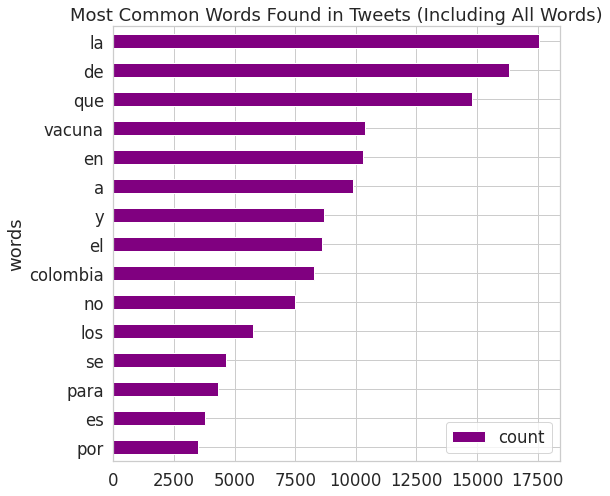

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets (Including All Words)")

plt.show()

### **Stopwords Removal**

We can see from the bar plot that the words with the highest frequency are not relevant words since don't give us any meaningful information. These are called 'stop words' and that's why we're going to remove them.

'nltk' package give us a list of stop words that we'll use to remove these empty words in our tweets.

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) # Set the language to Spanish

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's see some of these words:

In [ ]:
# View a few words from the set
list(stop_words)[0:20]

['otras',
 'ni',
 'estés',
 'siente',
 'fui',
 'somos',
 'había',
 'tú',
 'estarás',
 'habré',
 'tuvieras',
 'fuimos',
 'habrás',
 'mío',
 'sentidos',
 'otra',
 'sería',
 'suyas',
 'tendré',
 'de']

As we can see, the nltk package offer us a Spanish set of words. However, they're clearly in Spanish from Spain, this could lead us to a less efficient stop words removal process.

Now let's print again a tweet before removing stopwords ir order to do a comparison after the process.

In [ ]:
words_in_tweet[0]

['las', 'vacunas', 'matan', 'gente', 'y', 'no', 'lo', 'estan', 'diciendo']

In [ ]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['vacunas', 'matan', 'gente', 'estan', 'diciendo']

Once we've remove the stopwords it is clear that the amount of words are considerably lower. This is going to help us doing a more meaningful and efficiency analysis. Now, let's count the words again and plot a frequency barplot.

In [ ]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('vacuna', 10392),
 ('colombia', 8292),
 ('si', 2502),
 ('mas', 1834),
 ('covid', 1245),
 ('vacunas', 1206),
 ('gobierno', 1023),
 ('pais', 947),
 ('covid19', 854),
 ('gente', 793),
 ('va', 772),
 ('rusa', 753),
 ('van', 725),
 ('q', 710),
 ('ser', 706)]

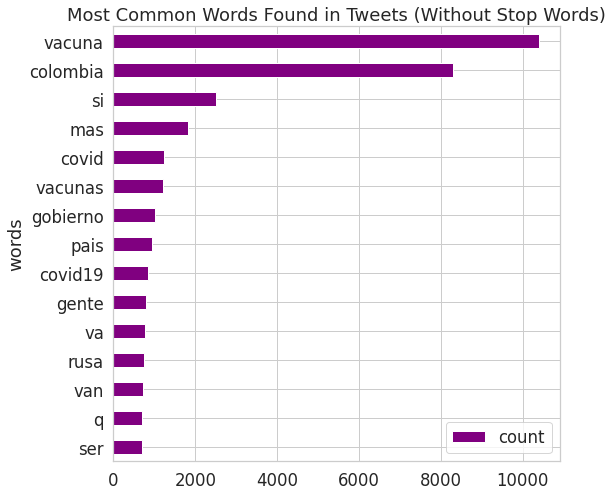

In [ ]:
words_count_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
words_count_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets (Without Stop Words)")

plt.show()

So now the highest frequency words seem to be 'more relevant' words than the one with the stop words.

### **Stemming / Lemmatization**

Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word. 

Since most of the packages that exist for NLP tasks are focused on English, it may be hard to achieve tasks such as stemming or lemmatization. However, there's a package called 'Stanza' that give us tools to create NLP models in many languages.

We are going to use **Lemmatization** so that you can see how it works.

In [ ]:
rejoined_tweets =  [' '.join(tweet) for tweet in tweets_nsw]
rejoined_tweets[6]
tweets["Texto"] = rejoined_tweets
tweets
tweets.to_csv('data/data_classifier/tweets_validationSINSTOPWORDS.csv')
tweets.shape

(14079, 5)

In [ ]:
processed_tweets = [stNLP(tweet) for tweet in rejoined_tweets]

In [ ]:
lemmatized_tweets = []
for t in processed_tweets:
  lemmatized_tweets.append([word.lemma for sent in t.sentences for word in sent.words])

In [ ]:
lemmatized_tweets[6]

['si',
 'enfermedad',
 'venir',
 'venir',
 'quedar',
 'él',
 '2021',
 'aun',
 'seguir',
 'tratar',
 'h1n1',
 'existir',
 'protocolo',
 'prevencion',
 'ciudadano',
 'deber',
 'cuidar',
 'yo',
 'cuidar',
 'resto',
 'cuarentena',
 'engano',
 'gobierno',
 'vacunarno']

In [ ]:
tweets_final =  [' '.join(tweet) for tweet in lemmatized_tweets]
tweets_final[6]

'si enfermedad venir venir quedar él 2021 aun seguir tratar h1n1 existir protocolo prevencion ciudadano deber cuidar yo cuidar resto cuarentena engano gobierno vacunarno'

In [ ]:
tweets["Texto"] = tweets_final
tweets

,Unnamed: 0,Nombre de usuario,Usuario,Fecha,Texto
0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,vacuna matar gente estar decir
1,1,Némesis,@MaryBol95533136,2021-01-27,aplicador anales nuevo formar regimen chino so...
2,2,S A N T I,@diluidoenagua,2021-01-27,encantar tanto gente decir asi si querer ir ll...
3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi querer vacunar hacer mas rapido
4,4,Carlos.,@Carloscdc06,2021-01-27,comar mierda hpta
...,...,...,...,...,...
14074,8508,Ells,@ellscms,2020-08-08,pregunta serio tú poneriar vacuna covid si lle...
14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,llegar vacuna colombio imaginar cartel covid19
14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,pesar haber ser consentir nacion hoy colombia ...
14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,ir llegar colombia vacuna covidoctubre 0 novie...


In [ ]:
tweets.to_csv('data/data_classifier/tweets_validationCONLEMMA.csv')

## **Word Vectorization**

# **RNN MODEL**

## Modelos con stopwords y sin lematización

In [20]:
tweets = pd.read_csv('data/data_classifier/tweets_process.csv')
tweets

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,no dejen de mirar numero de casos positivos de...,1
1,1,1,1,majo,@majoattacks,2021-03-06,y todos los adultos mayores de mi familia tamb...,1
2,2,2,2,#YoApruebo,@xapahernandez,2021-03-06,hasta el dalai lama se vacuno y todavia alguno...,1
3,3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,contra el terruqueo contra la desinformacion d...,1
4,4,4,4,Jose Ragas,@joseragas,2021-03-06,lo que hace willax no es libertad de expresion...,1
...,...,...,...,...,...,...,...,...
7659,7659,7659,2622,lid,@ldutari,2020-11-04,ni loca aunque sea obligatoria? y ni digan que...,0
7660,7660,7660,2623,Juan Manuel,@majud03,2020-11-04,ni mi familia metanse la vacuna bien en el,0
7661,7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,la vacuna del swine flu en 1976 ocasiono mas m...,0
7662,7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,me causa gracia xq todo es grieta ahora la vac...,0


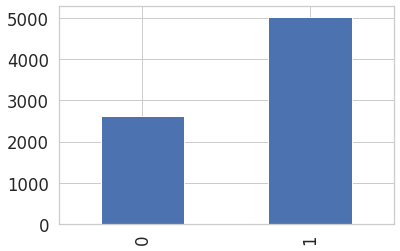

In [21]:
tweets['Sentimiento'].value_counts().sort_index().plot.bar()

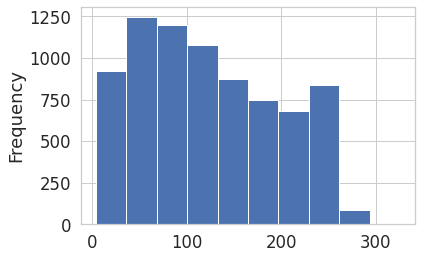

In [22]:
tweets["Texto"].str.len().plot.hist() #Número de carácteres

### Primera arquitectura

In [113]:
tokenizer1 = Tokenizer(num_words=17104, split=" ")
tokenizer1.fit_on_texts(tweets["Texto"].values)

x1 = tokenizer1.texts_to_sequences(tweets["Texto"].values)
x1 = pad_sequences(x1)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x1[0])
y1 = tweets['Sentimiento'].values
x1train, x1test, y1train, y1test = train_test_split(x1, y1, test_size = 0.3)

Sin tokenizar:  dejar mirar numero caso positivo ayer numero cti 992 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   48  299  484
  106  454  138  484 1403 5279  514]


In [106]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Embedding(input_dim=17102, output_dim=512, input_length=x1.shape[1]))
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.3))
model1.add(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.3))
model1.add(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.3))
#, dropout=0.3, recurrent_dropout=0.2))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(32, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 512)           8756224   
_________________________________________________________________
dropout (Dropout)            (None, 35, 512)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 35, 512)           2099200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 512)           2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 35, 512)           2099200   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [107]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [108]:
batch_size = 32
epochs = 100

#Callbacks

#ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau( #Sirve para reducir el Learning Rate dados ciertos parametros
#    monitor = 'val_loss',  #Monitorea el val_loss
#    factor = 0.1, #Es el factor para bajar el lr, es decir, new_lr = factor*lr
#    min_delta = 0.001, #Valor para que se considere que hubo una mejora
#    patience = 3, #Número de épocas si no hay cambios para que el lr disminuya
#    verbose = 0,
#    mode = 'auto', 
#    min_lr = 0.00001, #Learning rate mínimo
#    cooldown = 4 #Número de epochs sin monitorear luego de aplicar un nuevo learning rate
#)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 7, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history1 = model1.fit(x1train, y1train, validation_data=(x1test, y1test), callbacks=[EarlyStop],epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 25s 126ms/step - loss: 0.7181 - accuracy: 0.5222 - val_loss: 0.6943 - val_accuracy: 0.4630
Epoch 2/100
168/168 [==============================] - 20s 120ms/step - loss: 0.5916 - accuracy: 0.6565 - val_loss: 0.6801 - val_accuracy: 0.5696
Epoch 3/100
168/168 [==============================] - 20s 118ms/step - loss: 0.4997 - accuracy: 0.7605 - val_loss: 0.7001 - val_accuracy: 0.5635
Epoch 4/100
168/168 [==============================] - 20s 119ms/step - loss: 0.3609 - accuracy: 0.8432 - val_loss: 0.7031 - val_accuracy: 0.6983
Epoch 5/100
168/168 [==============================] - 20s 118ms/step - loss: 0.2929 - accuracy: 0.8929 - val_loss: 1.4561 - val_accuracy: 0.5152
Epoch 6/100
168/168 [==============================] - 20s 117ms/step - loss: 0.2351 - accuracy: 0.9163 - val_loss: 0.6149 - val_accuracy: 0.7487
Epoch 7/100
168/168 [==============================] - 20s 119ms/step - loss: 0.1929 - accuracy: 0.9311 - val_loss: 0.7904 -

In [109]:
name_model = 'modelGlobalMaxPooling1D17104v3'
model1.save('models/'+name_model+'.h5')

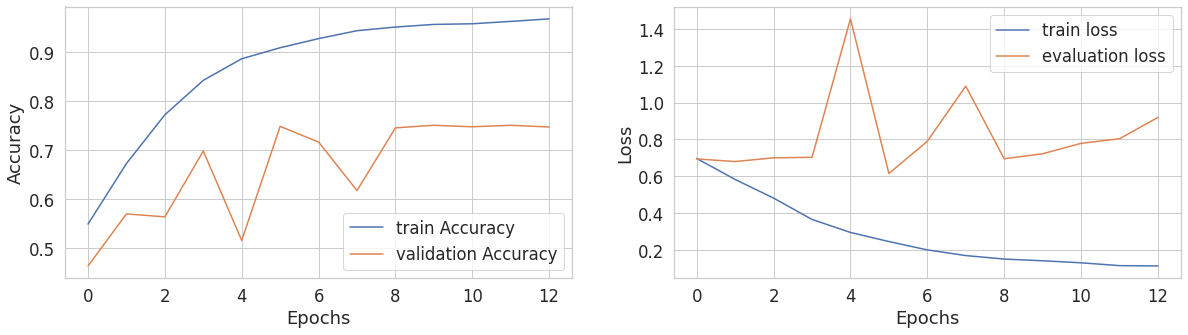

In [110]:
#@title **code**. To show prediction for a specific image
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history1.history['accuracy'], label='train Accuracy');
ax.plot(history1.history['val_accuracy'], label='validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history1.history['loss'], label='train loss');
ax.plot(history1.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [118]:
modeloLSTM1 = tf.keras.models.load_model('models/modelGlobalMaxPooling1D.h5')
pred1 = modeloLSTM1.predict_classes(x1test)
y1_real = y1test
conf_mx = confusion_matrix(y1_real, pred1)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y1_real), index = np.unique(y1_real))
heat_cm.index.name = 'Real'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y1_real,pred1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


InvalidArgumentError: ignored

#### Test the model

In [115]:
modeloLSTM1 = tf.keras.models.load_model('models/modelGlobalMaxPooling1D17104v3.h5')
tweets_validation1 = pd.read_csv('data/data_classifier/tweets_validation_NOLEMMA.csv')
x1validation = tokenizer1.texts_to_sequences(tweets_validation1["Texto"].values)
x1validation = pad_sequences(x1validation, maxlen=35)
predicciones1 = modeloLSTM1.predict(x1validation)
predicciones1

array([[8.2006693e-01],
       [9.9740773e-01],
       [1.2684089e-01],
       ...,
       [4.8926093e-02],
       [9.4252431e-01],
       [7.3192589e-04]], dtype=float32)

In [116]:
round_predicciones1 = []
for i in range(len(predicciones1)):
  if predicciones1[i]<0.5:
    round_predicciones1.append(0)
  else:
    round_predicciones1.append(1)

tweets_validation1["Sentimiento"] = round_predicciones1
tweets_validation1.to_csv('data/data_classifier/resultados/tweets_validation_modelGlobalMaxPooling1Dv3.csv')
tweets_validation1

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,las vacunas matan gente y no lo estan diciendo,1
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicadores anales la nueva forma del regimen ...,1
2,2,2,S A N T I,@diluidoenagua,2021-01-27,me encanta que haya tanta gente diciendo asi p...,0
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi los que nos queremos vacunar lo hace...,0
4,4,4,Carlos.,@Carloscdc06,2021-01-27,coman mierda hptas,1
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta muy seria ustedes se pondrian la vacu...,1
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,cuando llegue la vacuna a colombia se imaginan...,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,a pesar de haber sido los consentidos de la na...,0
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,cuando va a llegar a colombia la vacuna contra...,1


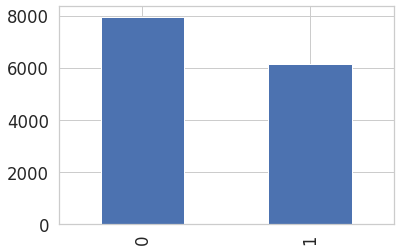

In [117]:
tweets_validation1['Sentimiento'].value_counts().sort_index().plot.bar()

### Segunda arquitectura

In [35]:
tokenizer = Tokenizer(num_words=17104, split=" ")
tokenizer.fit_on_texts(tweets["Texto"].values)

x2 = tokenizer.texts_to_sequences(tweets["Texto"].values)
x2 = pad_sequences(x2)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x2[0])
y2 = tweets['Sentimiento'].values
x2train, x2test, y2train, y2test = train_test_split(x2, y2, test_size = 0.3)

Sin tokenizar:  no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    7  345    1 2197  699    1  306 1766    1  196    4  699
    8 1767 7332    4  553]


In [37]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=17104, output_dim=512, input_length=x2.shape[1]))
model2.add(tf.keras.layers.SpatialDropout1D(0.2))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True)))#, dropout=0.3, recurrent_dropout=0.3))

model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(32, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 61, 512)           8757248   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 61, 512)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 61, 1024)          4198400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               2623488   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

In [38]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
batch_size = 32
epochs = 100

#Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 7, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history2 = model2.fit(x2train, y2train, validation_data=(x2test, y2test) ,callbacks=[EarlyStop] ,epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 31s 152ms/step - loss: 0.6634 - accuracy: 0.6030 - val_loss: 0.5411 - val_accuracy: 0.7370
Epoch 2/100
168/168 [==============================] - 24s 144ms/step - loss: 0.4651 - accuracy: 0.8039 - val_loss: 0.4416 - val_accuracy: 0.7748
Epoch 3/100
168/168 [==============================] - 24s 145ms/step - loss: 0.2762 - accuracy: 0.9180 - val_loss: 0.7268 - val_accuracy: 0.7887
Epoch 4/100
168/168 [==============================] - 24s 145ms/step - loss: 0.1779 - accuracy: 0.9461 - val_loss: 0.6564 - val_accuracy: 0.7774
Epoch 5/100
168/168 [==============================] - 24s 144ms/step - loss: 0.1083 - accuracy: 0.9690 - val_loss: 0.9962 - val_accuracy: 0.7748
Epoch 6/100
168/168 [==============================] - 24s 144ms/step - loss: 0.0662 - accuracy: 0.9820 - val_loss: 1.0430 - val_accuracy: 0.7713
Epoch 7/100
168/168 [==============================] - 24s 144ms/step - loss: 0.0723 - accuracy: 0.9821 - val_loss: 1.5139 -

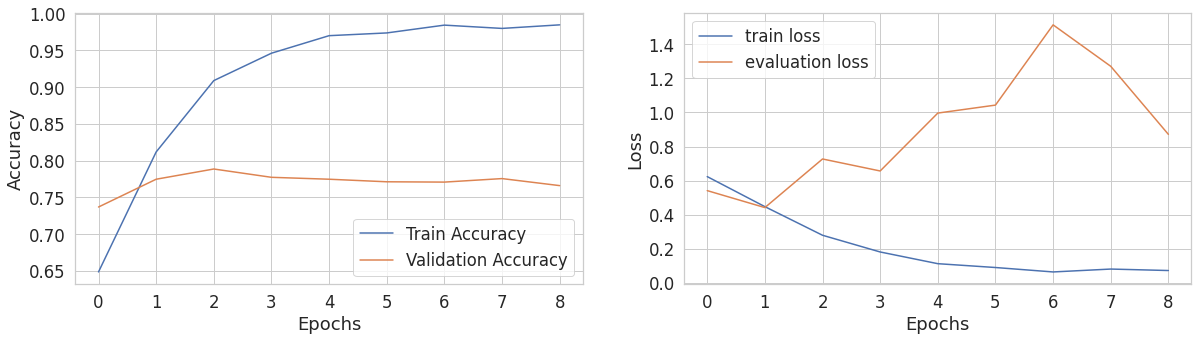

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history2.history['accuracy'], label='Train Accuracy');
ax.plot(history2.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history2.history['loss'], label='train loss');
ax.plot(history2.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


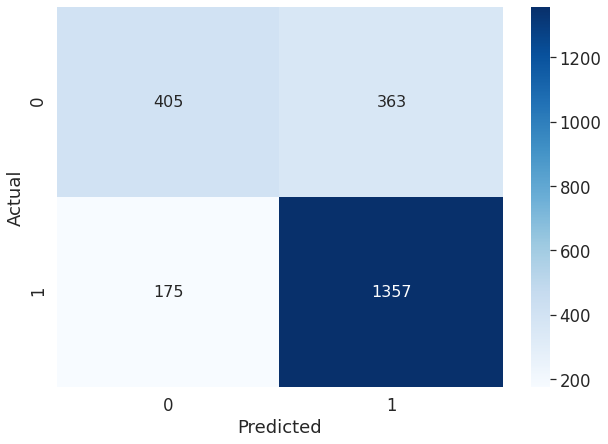

              precision    recall  f1-score   support

           0       0.70      0.53      0.60       768
           1       0.79      0.89      0.83      1532

    accuracy                           0.77      2300
   macro avg       0.74      0.71      0.72      2300
weighted avg       0.76      0.77      0.76      2300



In [52]:
pred2 = model2.predict_classes(x2test)
y2_real = y2test
conf_mx = confusion_matrix(y2_real, pred2)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y2_real), index = np.unique(y2_real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y2_real,pred2))

In [ ]:
name_model = 'modelBidirectional'
model2.save('models/'+name_model+'.h5')

#### Test the model

In [ ]:
modeloLSTM2 = tf.keras.models.load_model('models/modelBidirectional.h5')
tweets_validation2 = pd.read_csv('data/data_classifier/tweets_validation_NOLEMMA.csv')
x2_validation = tokenizer.texts_to_sequences(tweets_validation2["Texto"].values)
x2_validation = pad_sequences(x2_validation, maxlen=54)
predicciones2 = modeloLSTM2.predict(x2_validation)
predicciones2

array([[0.04838192],
       [0.04067377],
       [0.7697587 ],
       ...,
       [0.9999893 ],
       [0.6900864 ],
       [0.999998  ]], dtype=float32)

In [ ]:
round_predicciones2 = []
for i in range(len(predicciones2)):
  if predicciones2[i]<0.5:
    round_predicciones2.append(0)
  else:
    round_predicciones2.append(1)

tweets_validation2["Sentimiento"] = round_predicciones2
tweets_validation2.to_csv('data/data_classifier/resultados/tweets_validation_modelBidirectional.csv')
tweets_validation2

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,las vacunas matan gente y no lo estan diciendo,0
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicadores anales la nueva forma del regimen ...,0
2,2,2,S A N T I,@diluidoenagua,2021-01-27,me encanta que haya tanta gente diciendo asi p...,1
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi los que nos queremos vacunar lo hace...,1
4,4,4,Carlos.,@Carloscdc06,2021-01-27,coman mierda hptas,1
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta muy seria ustedes se pondrian la vacu...,1
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,cuando llegue la vacuna a colombia se imaginan...,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,a pesar de haber sido los consentidos de la na...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,cuando va a llegar a colombia la vacuna contra...,1


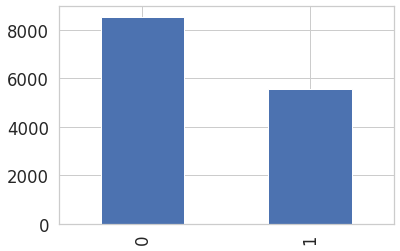

In [ ]:
tweets_validation2['Sentimiento'].value_counts().sort_index().plot.bar()

### Tercera arquitectura

In [48]:
tokenizer3 = Tokenizer(num_words=17104, split=" ")
tokenizer3.fit_on_texts(tweets["Texto"].values)

x3 = tokenizer3.texts_to_sequences(tweets["Texto"].values)
x3 = pad_sequences(x3)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x3[0])
y3 = tweets['Sentimiento'].values
x3train, x3test, y3train, y3test = train_test_split(x3, y3, test_size = 0.3)

Sin tokenizar:  no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    7  345    1 2197  699    1  306 1766    1  196    4  699
    8 1767 7332    4  553]


In [49]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Embedding(input_dim=17104, output_dim=512, input_length=x3.shape[1]))
model3.add(tf.keras.layers.SpatialDropout1D(0.2))
model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='tanh', return_sequences=True)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(256, activation='relu'))
model3.add(tf.keras.layers.Dense(32, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 61, 512)           8757248   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 61, 512)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 61, 1024)          3151872   
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [50]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [51]:
batch_size = 32
epochs = 100

#Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 10, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history3 = model3.fit(x3train, y3train, validation_data=(x3test, y3test) ,callbacks=[EarlyStop] ,epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 23s 118ms/step - loss: 0.6253 - accuracy: 0.6559 - val_loss: 0.4803 - val_accuracy: 0.7909
Epoch 2/100
168/168 [==============================] - 19s 114ms/step - loss: 0.4503 - accuracy: 0.8110 - val_loss: 0.4242 - val_accuracy: 0.7913
Epoch 3/100
168/168 [==============================] - 19s 112ms/step - loss: 0.2272 - accuracy: 0.9175 - val_loss: 0.4846 - val_accuracy: 0.7843
Epoch 4/100
168/168 [==============================] - 19s 112ms/step - loss: 0.1300 - accuracy: 0.9605 - val_loss: 0.5558 - val_accuracy: 0.7826
Epoch 5/100
168/168 [==============================] - 19s 112ms/step - loss: 0.0853 - accuracy: 0.9839 - val_loss: 1.0573 - val_accuracy: 0.7804
Epoch 6/100
168/168 [==============================] - 19s 111ms/step - loss: 0.0599 - accuracy: 0.9881 - val_loss: 0.9443 - val_accuracy: 0.7900
Epoch 7/100
168/168 [==============================] - 19s 115ms/step - loss: 0.0483 - accuracy: 0.9898 - val_loss: 1.9249 -

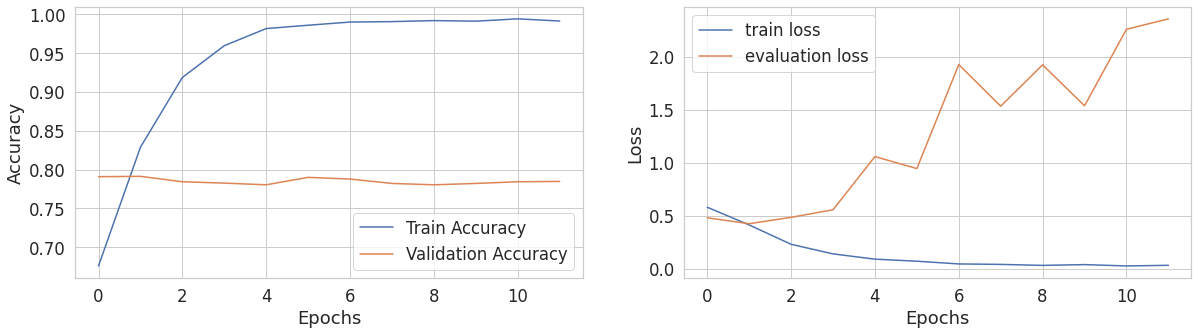

In [53]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history3.history['accuracy'], label='Train Accuracy');
ax.plot(history3.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history3.history['loss'], label='train loss');
ax.plot(history3.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


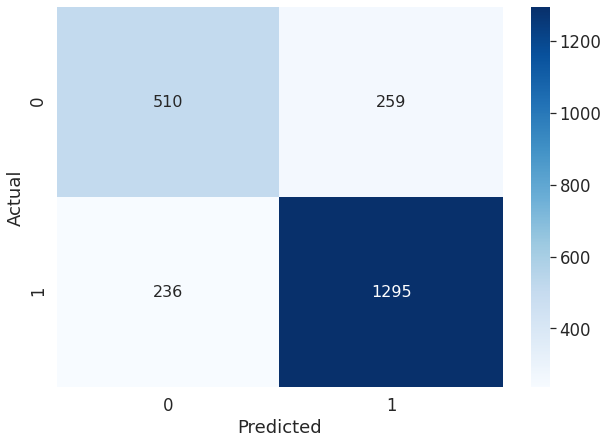

              precision    recall  f1-score   support

           0       0.68      0.66      0.67       769
           1       0.83      0.85      0.84      1531

    accuracy                           0.78      2300
   macro avg       0.76      0.75      0.76      2300
weighted avg       0.78      0.78      0.78      2300



In [54]:
pred3 = model3.predict_classes(x3test)
y3_real = y3test
conf_mx = confusion_matrix(y3_real, pred3)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y2_real), index = np.unique(y3_real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y3_real,pred3))

In [ ]:
name_model = 'modelBidirectionalAndMaxGRU'
model3.save('models/'+name_model+'.h5')

#### Test the model

In [ ]:
modeloLSTM3 = tf.keras.models.load_model('models/modelBidirectionalAndMax.h5')
tweets_validation3 = pd.read_csv('data/data_classifier/tweets_validation_NOLEMMA.csv')
x3 = tokenizer.texts_to_sequences(tweets_validation3["Texto"].values)
x3 = pad_sequences(x3, maxlen=54)
predicciones3 = modeloLSTM3.predict(x)
predicciones3

array([[0.80326414],
       [0.9515966 ],
       [0.02755043],
       ...,
       [1.        ],
       [0.9999975 ],
       [0.94871   ]], dtype=float32)

In [ ]:
round_predicciones3 = []
for i in range(len(predicciones3)):
  if predicciones3[i]<0.5:
    round_predicciones3.append(0)
  else:
    round_predicciones3.append(1)

tweets_validation3["Sentimiento"] = round_predicciones3
tweets_validation3.to_csv('data/data_classifier/resultados/tweets_validation_modelBidirectionalAndMax.csv')
tweets_validation3

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,las vacunas matan gente y no lo estan diciendo,1
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicadores anales la nueva forma del regimen ...,1
2,2,2,S A N T I,@diluidoenagua,2021-01-27,me encanta que haya tanta gente diciendo asi p...,0
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi los que nos queremos vacunar lo hace...,1
4,4,4,Carlos.,@Carloscdc06,2021-01-27,coman mierda hptas,0
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta muy seria ustedes se pondrian la vacu...,1
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,cuando llegue la vacuna a colombia se imaginan...,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,a pesar de haber sido los consentidos de la na...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,cuando va a llegar a colombia la vacuna contra...,1


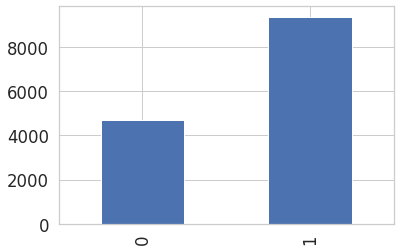

In [ ]:
tweets_validation3['Sentimiento'].value_counts().sort_index().plot.bar()

## Modelos sin stoptwords y con lematización

In [55]:
tweets = pd.read_csv('data/data_classifier/tweetsCONLEMMA.csv')
tweets

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,dejar mirar numero caso positivo ayer numero c...,1
1,1,1,1,majo,@majoattacks,2021-03-06,adulto mayor familia tambien hacer conversar a...,1
2,2,2,2,#YoApruebo,@xapahernandez,2021-03-06,dalai lama vacuno todavia dar color,1
3,3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,terruqueo desinformacion willaxtv periodismo l...,1
4,4,4,4,Jose Ragas,@joseragas,2021-03-06,hacer willax libertad expresion campana delibe...,1
...,...,...,...,...,...,...,...,...
7659,7659,7659,2622,lid,@ldutari,2020-11-04,loco aunque obligatorio decir gratis pagar,0
7660,7660,7660,2623,Juan Manuel,@majud03,2020-11-04,familia metansar vacuna bien,0
7661,7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,vacuna swine flu 1976 ocasionar mas muerte enf...,0
7662,7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,causa gracia xq grieta ahora vacuna unico dive...,0


In [56]:
def to_str(s):
  s = str(s)
  return s

In [57]:
tweets["Texto"] = tweets["Texto"].apply(to_str)
tweets

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,dejar mirar numero caso positivo ayer numero c...,1
1,1,1,1,majo,@majoattacks,2021-03-06,adulto mayor familia tambien hacer conversar a...,1
2,2,2,2,#YoApruebo,@xapahernandez,2021-03-06,dalai lama vacuno todavia dar color,1
3,3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,terruqueo desinformacion willaxtv periodismo l...,1
4,4,4,4,Jose Ragas,@joseragas,2021-03-06,hacer willax libertad expresion campana delibe...,1
...,...,...,...,...,...,...,...,...
7659,7659,7659,2622,lid,@ldutari,2020-11-04,loco aunque obligatorio decir gratis pagar,0
7660,7660,7660,2623,Juan Manuel,@majud03,2020-11-04,familia metansar vacuna bien,0
7661,7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,vacuna swine flu 1976 ocasionar mas muerte enf...,0
7662,7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,causa gracia xq grieta ahora vacuna unico dive...,0


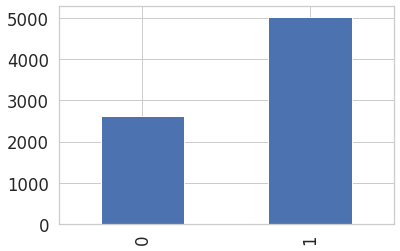

In [58]:
tweets['Sentimiento'].value_counts().sort_index().plot.bar()

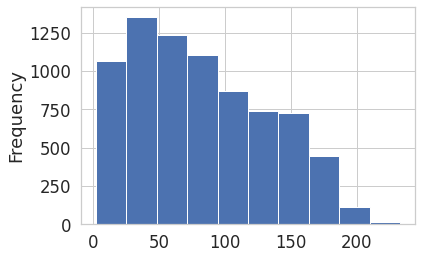

In [59]:
tweets["Texto"].str.len().plot.hist() #Número de carácteres

### Primera arquitectura

In [63]:
tokenizer1_1 = Tokenizer(num_words=12505, split=" ")
tokenizer1_1.fit_on_texts(tweets["Texto"].values)

x1_lem = tokenizer1_1.texts_to_sequences(tweets["Texto"].values)
x1_lem = pad_sequences(x1_lem)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x1_lem[0])
y1_lem = tweets['Sentimiento'].values
x1lemtrain, x1lemtest, y1lemtrain, y1lemtest = train_test_split(x1_lem, y1_lem, test_size = 0.3)

Sin tokenizar:  dejar mirar numero caso positivo ayer numero cti 992 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   48  299  484
  106  454  138  484 1403 5279  514]


In [64]:
model1_1 = tf.keras.models.Sequential()
model1_1.add(tf.keras.layers.Embedding(input_dim=12505, output_dim=512, input_length=x1_lem.shape[1]))
model1_1.add(tf.keras.layers.SpatialDropout1D(0.2))
model1_1.add(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.3))
model1_1.add(tf.keras.layers.GlobalMaxPooling1D())
model1_1.add(tf.keras.layers.Dense(256, activation='relu'))
model1_1.add(tf.keras.layers.Dense(32, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model1_1.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model1_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 512)           6402560   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 35, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 35, 512)           2099200   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_10 (Dense)             (None, 16)               

In [65]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model1_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [66]:
batch_size = 32
epochs = 100

#Callbacks

#ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau( #Sirve para reducir el Learning Rate dados ciertos parametros
#    monitor = 'val_loss',  #Monitorea el val_loss
#    factor = 0.1, #Es el factor para bajar el lr, es decir, new_lr = factor*lr
#    min_delta = 0.001, #Valor para que se considere que hubo una mejora
#    patience = 3, #Número de épocas si no hay cambios para que el lr disminuya
#    verbose = 0,
#    mode = 'auto', 
#    min_lr = 0.00001, #Learning rate mínimo
#    cooldown = 4 #Número de epochs sin monitorear luego de aplicar un nuevo learning rate
#)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 20, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history1_1 = model1_1.fit(x1lemtrain, y1lemtrain, validation_data=(x1lemtest, y1lemtest), callbacks=[EarlyStop],epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 14s 77ms/step - loss: 0.6514 - accuracy: 0.6560 - val_loss: 0.6223 - val_accuracy: 0.6609
Epoch 2/100
168/168 [==============================] - 12s 73ms/step - loss: 0.5777 - accuracy: 0.6772 - val_loss: 0.4756 - val_accuracy: 0.7635
Epoch 3/100
168/168 [==============================] - 12s 72ms/step - loss: 0.3857 - accuracy: 0.8311 - val_loss: 0.5156 - val_accuracy: 0.7743
Epoch 4/100
168/168 [==============================] - 12s 72ms/step - loss: 0.2490 - accuracy: 0.8946 - val_loss: 0.4557 - val_accuracy: 0.7813
Epoch 5/100
168/168 [==============================] - 12s 73ms/step - loss: 0.1698 - accuracy: 0.9398 - val_loss: 0.5861 - val_accuracy: 0.7835
Epoch 6/100
168/168 [==============================] - 12s 74ms/step - loss: 0.1392 - accuracy: 0.9498 - val_loss: 0.6062 - val_accuracy: 0.7787
Epoch 7/100
168/168 [==============================] - 12s 72ms/step - loss: 0.0978 - accuracy: 0.9659 - val_loss: 0.6792 - val_ac

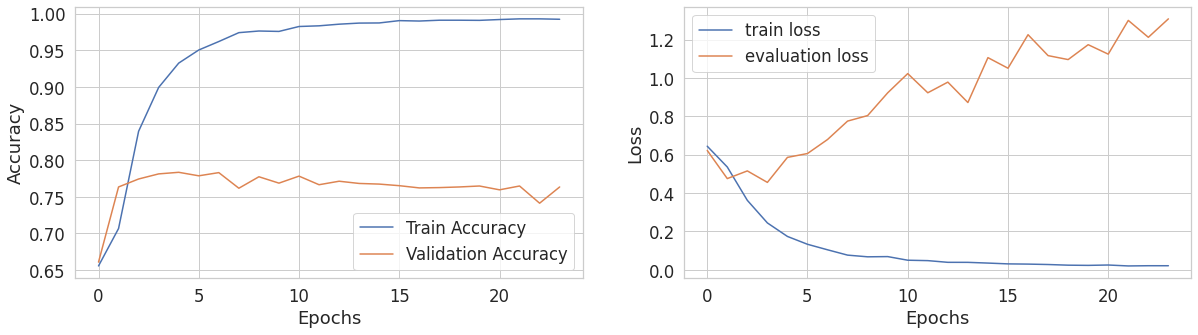

In [67]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history1_1.history['accuracy'], label='Train Accuracy');
ax.plot(history1_1.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history1_1.history['loss'], label='train loss');
ax.plot(history1_1.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


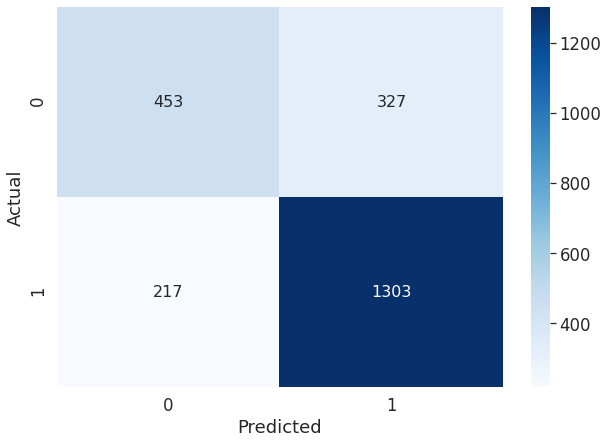

              precision    recall  f1-score   support

           0       0.68      0.58      0.62       780
           1       0.80      0.86      0.83      1520

    accuracy                           0.76      2300
   macro avg       0.74      0.72      0.73      2300
weighted avg       0.76      0.76      0.76      2300



In [68]:
pred1_1 = model1_1.predict_classes(x1lemtest)
y1_1real = y1lemtest
conf_mx = confusion_matrix(y1_1real, pred1_1)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y1_1real), index = np.unique(y1_1real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y1_1real,pred1_1))

In [69]:
name_model = 'modelGlobalMaxPooling1DLEM12505'
model1_1.save('models/'+name_model+'.h5')

#### Test the model

In [76]:
modeloLSTM1_1 = tf.keras.models.load_model('models/modelGlobalMaxPooling1DLEM12505.h5')
tweets_validation1_1 = pd.read_csv('data/data_classifier/tweets_validationCONLEMMA.csv')
tweets_validation1_1["Texto"] = tweets_validation1_1["Texto"].apply(to_str)
x1_1validation = tokenizer1_1.texts_to_sequences(tweets_validation1_1["Texto"].values)
x1_1validation = pad_sequences(x1_1validation, maxlen=35)
predicciones1_1 = modeloLSTM1_1.predict(x1_1validation)
predicciones1_1

array([[0.00661932],
       [0.9999993 ],
       [0.03650632],
       ...,
       [1.        ],
       [0.99994075],
       [0.19079147]], dtype=float32)

In [77]:
round_predicciones1_1 = []
for i in range(len(predicciones1_1)):
  if predicciones1_1[i]<0.5:
    round_predicciones1_1.append(0)
  else:
    round_predicciones1_1.append(1)

tweets_validation1_1["Sentimiento"] = round_predicciones1_1
tweets_validation1_1.to_csv('data/data_classifier/resultados/tweets_validation_modelGlobalMaxPooling1DLEM12505.csv')
tweets_validation1_1

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,vacuna matar gente estar decir,0
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicador anales nuevo formar regimen chino so...,1
2,2,2,S A N T I,@diluidoenagua,2021-01-27,encantar tanto gente decir asi si querer ir ll...,0
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi querer vacunar hacer mas rapido,0
4,4,4,Carlos.,@Carloscdc06,2021-01-27,comar mierda hpta,0
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta serio tú poneriar vacuna covid si lle...,1
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,llegar vacuna colombio imaginar cartel covid19,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,pesar haber ser consentir nacion hoy colombia ...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,ir llegar colombia vacuna covidoctubre 0 novie...,1


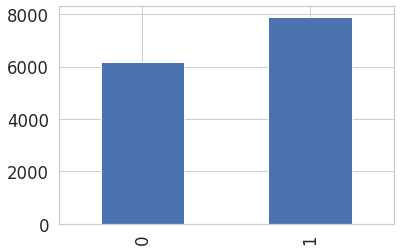

In [78]:
tweets_validation1_1['Sentimiento'].value_counts().sort_index().plot.bar()

### Segunda arquitectura

In [79]:
tokenizer1_2 = Tokenizer(num_words=12505, split=" ")
tokenizer1_2.fit_on_texts(tweets["Texto"].values)

x2lem = tokenizer.texts_to_sequences(tweets["Texto"].values)
x2lem = pad_sequences(x2lem)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x2lem[0])
y2lem = tweets['Sentimiento'].values
x2lemtrain, x2lemtest, y2lemtrain, y2lemtest = train_test_split(x2lem, y2lem, test_size = 0.3)

Sin tokenizar:  dejar mirar numero caso positivo ayer numero cti 992 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   48  299  484
  106  454  138  484 1403 5279  514]


In [85]:
model2_1 = tf.keras.models.Sequential()
model2_1.add(tf.keras.layers.Embedding(input_dim=12505, output_dim=512, input_length=x2lem.shape[1]))
model2_1.add(tf.keras.layers.SpatialDropout1D(0.2))
model2_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True)))
model2_1.add(tf.keras.layers.SpatialDropout1D(0.2))
model2_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True)))#, dropout=0.3, recurrent_dropout=0.3))
model2_1.add(tf.keras.layers.GlobalMaxPooling1D())
model2_1.add(tf.keras.layers.Dense(256, activation='relu'))
model2_1.add(tf.keras.layers.BatchNormalization())
model2_1.add(tf.keras.layers.Dense(128, activation='relu'))
model2_1.add(tf.keras.layers.Dropout(0.4))
model2_1.add(tf.keras.layers.Dense(64, activation='relu'))
model2_1.add(tf.keras.layers.BatchNormalization())
model2_1.add(tf.keras.layers.Dense(32, activation='relu'))
model2_1.add(tf.keras.layers.Dropout(0.2))
model2_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 512)           6402560   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 35, 512)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 35, 1024)          4198400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 35, 1024)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 1024)          6295552   
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

In [86]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [87]:
batch_size = 64
epochs = 100

#Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 20, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history2_1 = model2_1.fit(x2lemtrain, y2lemtrain, validation_data=(x2lemtest, y2lemtest) ,callbacks=[EarlyStop] ,epochs = epochs, batch_size=batch_size)

Epoch 1/100
84/84 [==============================] - 17s 147ms/step - loss: 0.7253 - accuracy: 0.6127 - val_loss: 0.6397 - val_accuracy: 0.6448
Epoch 2/100
84/84 [==============================] - 11s 131ms/step - loss: 0.6098 - accuracy: 0.6560 - val_loss: 1.5794 - val_accuracy: 0.6448
Epoch 3/100
84/84 [==============================] - 11s 131ms/step - loss: 0.4050 - accuracy: 0.8142 - val_loss: 1.5363 - val_accuracy: 0.6757
Epoch 4/100
84/84 [==============================] - 11s 131ms/step - loss: 0.2439 - accuracy: 0.9117 - val_loss: 1.2065 - val_accuracy: 0.6752
Epoch 5/100
84/84 [==============================] - 11s 130ms/step - loss: 0.1673 - accuracy: 0.9420 - val_loss: 0.9620 - val_accuracy: 0.7696
Epoch 6/100
84/84 [==============================] - 11s 131ms/step - loss: 0.1138 - accuracy: 0.9621 - val_loss: 1.3420 - val_accuracy: 0.7322
Epoch 7/100
84/84 [==============================] - 11s 132ms/step - loss: 0.0866 - accuracy: 0.9754 - val_loss: 1.0829 - val_accuracy:

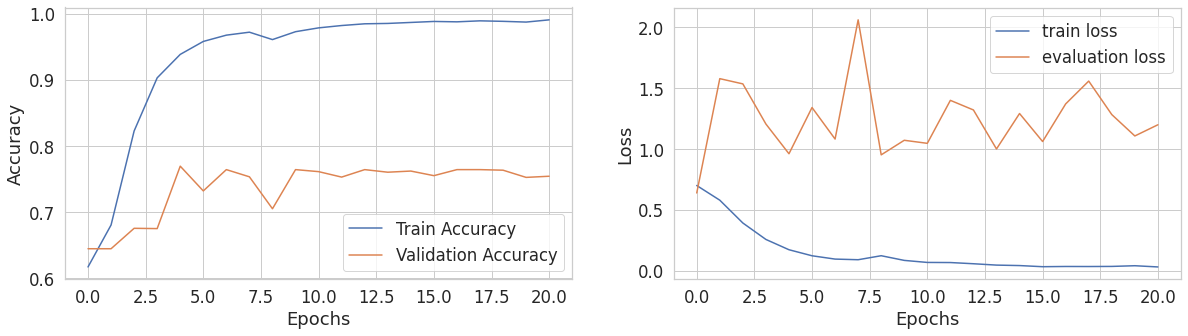

In [88]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history2_1.history['accuracy'], label='Train Accuracy');
ax.plot(history2_1.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history2_1.history['loss'], label='train loss');
ax.plot(history2_1.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


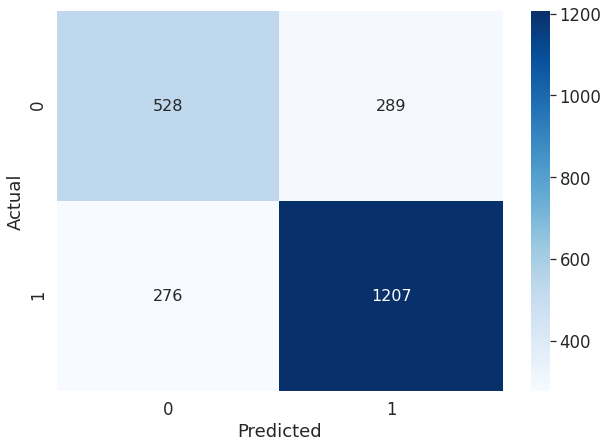

              precision    recall  f1-score   support

           0       0.66      0.65      0.65       817
           1       0.81      0.81      0.81      1483

    accuracy                           0.75      2300
   macro avg       0.73      0.73      0.73      2300
weighted avg       0.75      0.75      0.75      2300



In [89]:
pred2_1 = model2_1.predict_classes(x2lemtest)
y2_1real = y2lemtest
conf_mx = confusion_matrix(y2_1real, pred2_1)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y2_1real), index = np.unique(y2_1real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y2_1real,pred2_1))

In [90]:
name_model = 'modelBidirectionalLEMBatch'
model2_1.save('models/'+name_model+'.h5')

#### Test the model

In [97]:
modeloLSTM2_1 = tf.keras.models.load_model('models/modelBidirectionalLEMBatch.h5')
tweets_validation2_1 = pd.read_csv('data/data_classifier/tweets_validationCONLEMMA.csv')
tweets_validation2_1["Texto"] = tweets_validation2_1["Texto"].apply(to_str)

In [102]:
x2_1validation = tokenizer.texts_to_sequences(tweets_validation2_1["Texto"].values)
x2_1validation = pad_sequences(x2_1validation, maxlen=35)
predicciones2_1 = modeloLSTM2_1.predict(x2_1validation)
predicciones2_1

array([[1.0557460e-03],
       [9.9938953e-01],
       [5.0599209e-04],
       ...,
       [5.6037247e-01],
       [6.3990319e-01],
       [9.4244155e-05]], dtype=float32)

In [103]:
round_predicciones2_1 = []
for i in range(len(predicciones2_1)):
  if predicciones2_1[i]<0.5:
    round_predicciones2_1.append(0)
  else:
    round_predicciones2_1.append(1)

tweets_validation2_1["Sentimiento"] = round_predicciones2_1
tweets_validation2_1.to_csv('data/data_classifier/resultados/tweets_validation_modelBidirectionalLEM.csv')
tweets_validation2_1

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,vacuna matar gente estar decir,0
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicador anales nuevo formar regimen chino so...,1
2,2,2,S A N T I,@diluidoenagua,2021-01-27,encantar tanto gente decir asi si querer ir ll...,0
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi querer vacunar hacer mas rapido,1
4,4,4,Carlos.,@Carloscdc06,2021-01-27,comar mierda hpta,0
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta serio tú poneriar vacuna covid si lle...,0
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,llegar vacuna colombio imaginar cartel covid19,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,pesar haber ser consentir nacion hoy colombia ...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,ir llegar colombia vacuna covidoctubre 0 novie...,1


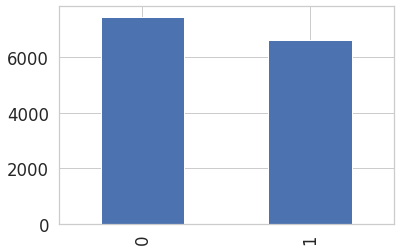

In [104]:
tweets_validation2_1['Sentimiento'].value_counts().sort_index().plot.bar()

### Tercera arquitectura

In [ ]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(tweets["Texto"].values)

x3lem = tokenizer.texts_to_sequences(tweets["Texto"].values)
x3lem = pad_sequences(x3lem)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x3lem[0])
y3lem = tweets['Sentimiento'].values
x3lemtrain, x3lemtest, y3lemtrain, y3lemtest = train_test_split(x3lem, y3lem, test_size = 0.3)

Sin tokenizar:  dejar mirar numero caso positivo ayer numero cti 992 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   48  299
  484  106  454  138  484 1403  514]


In [ ]:
model3_1 = tf.keras.models.Sequential()
model3_1.add(tf.keras.layers.Embedding(input_dim=12505, output_dim=256, input_length=x3lem.shape[1]))
model3_1.add(tf.keras.layers.SpatialDropout1D(0.2))
model3_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='tanh', return_sequences=True)))
model3_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='tanh', return_sequences=True)))##, dropout=0.3, recurrent_dropout=0.3))
model3_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='tanh',return_sequences=True)))
model3_1.add(tf.keras.layers.GlobalMaxPooling1D())
model3_1.add(tf.keras.layers.Dense(256, activation='relu'))
model3_1.add(tf.keras.layers.Dense(32, activation='relu'))
model3_1.add(tf.keras.layers.Dropout(0.5))
model3_1.add(tf.keras.layers.Dense(16, activation='relu'))
model3_1.add(tf.keras.layers.Dropout(0.5))
model3_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 256)           3201280   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 35, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 35, 512)           1050624   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 512)           1574912   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 35, 512)           1574912   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model3_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
batch_size = 32
epochs = 100

#Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 20, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history3_1 = model3_1.fit(x3lemtrain, y3lemtrain, validation_data=(x3lemtest, y3lemtest) ,callbacks=[EarlyStop] ,epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 18s 69ms/step - loss: 0.6512 - accuracy: 0.6169 - val_loss: 0.5052 - val_accuracy: 0.7578
Epoch 2/100
168/168 [==============================] - 9s 54ms/step - loss: 0.4956 - accuracy: 0.7435 - val_loss: 0.4631 - val_accuracy: 0.7561
Epoch 3/100
168/168 [==============================] - 9s 55ms/step - loss: 0.3721 - accuracy: 0.8354 - val_loss: 0.4397 - val_accuracy: 0.7883
Epoch 4/100
168/168 [==============================] - 9s 54ms/step - loss: 0.2697 - accuracy: 0.8953 - val_loss: 0.4708 - val_accuracy: 0.7909
Epoch 5/100
168/168 [==============================] - 9s 54ms/step - loss: 0.2074 - accuracy: 0.9270 - val_loss: 0.8712 - val_accuracy: 0.7839
Epoch 6/100
168/168 [==============================] - 9s 54ms/step - loss: 0.1576 - accuracy: 0.9341 - val_loss: 0.8142 - val_accuracy: 0.7787
Epoch 7/100
168/168 [==============================] - 9s 54ms/step - loss: 0.1507 - accuracy: 0.9394 - val_loss: 1.1802 - val_accuracy

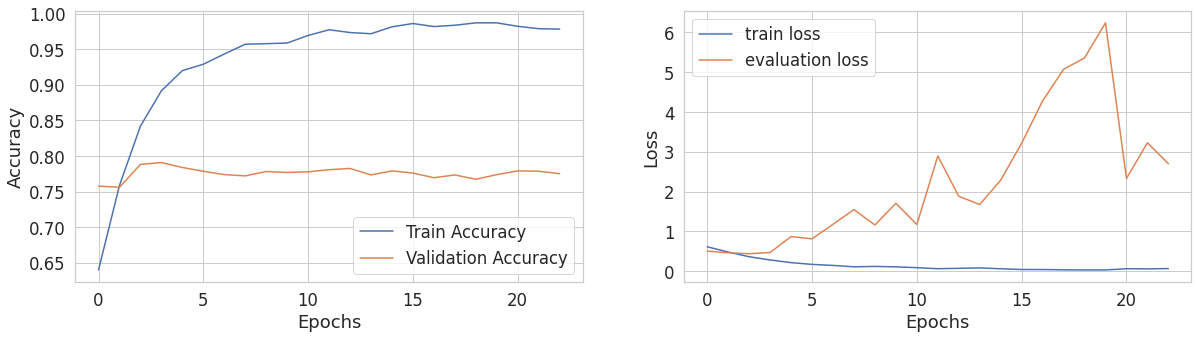

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history3_1.history['accuracy'], label='Train Accuracy');
ax.plot(history3_1.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history3_1.history['loss'], label='train loss');
ax.plot(history3_1.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


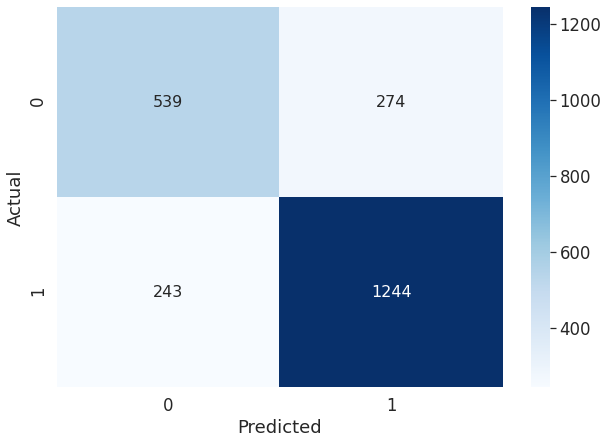

In [ ]:
pred3_1 = model3_1.predict_classes(x3lemtest)
y3_1real = y3lemtest
conf_mx = confusion_matrix(y3_1real, pred3_1)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y3_1real), index = np.unique(y3_1real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()

In [ ]:
name_model = 'modelBidirectionalAndMaxLEM'
model3_1.save('models/'+name_model+'.h5')

#### Test the model

In [ ]:
modeloLSTM3_1 = tf.keras.models.load_model('models/modelBidirectionalAndMaxLEM.h5')
tweets_validation3_1 = pd.read_csv('data/data_classifier/tweets_validationCONLEMMA.csv')
tweets_validation3_1["Texto"] = tweets_validation3_1["Texto"].apply(to_str)
x3_1validation = tokenizer.texts_to_sequences(tweets_validation3_1["Texto"].values)
x3_1validation = pad_sequences(x, maxlen=35)
predicciones3_1 = modeloLSTM3_1.predict(x3_1validation)
predicciones3_1

array([[5.3296793e-01],
       [4.2285176e-04],
       [1.0000000e+00],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [ ]:
round_predicciones3_1 = []
for i in range(len(predicciones3_1)):
  if predicciones3_1[i]<0.5:
    round_predicciones3_1.append(0)
  else:
    round_predicciones3_1.append(1)

tweets_validation3_1["Sentimiento"] = round_predicciones3_1
tweets_validation3_1.to_csv('data/data_classifier/resultados/tweets_validation_modelBidirectionalAndMaxLEM.csv')
tweets_validation3_1

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,vacuna matar gente estar decir,1
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicador anales nuevo formar regimen chino so...,0
2,2,2,S A N T I,@diluidoenagua,2021-01-27,encantar tanto gente decir asi si querer ir ll...,1
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi querer vacunar hacer mas rapido,1
4,4,4,Carlos.,@Carloscdc06,2021-01-27,comar mierda hpta,1
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta serio tú poneriar vacuna covid si lle...,1
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,llegar vacuna colombio imaginar cartel covid19,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,pesar haber ser consentir nacion hoy colombia ...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,ir llegar colombia vacuna covidoctubre 0 novie...,1


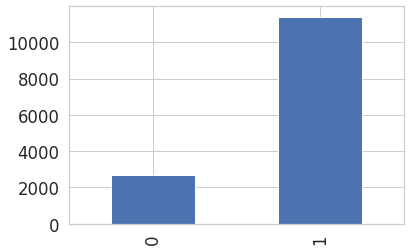

In [ ]:
tweets_validation3_1['Sentimiento'].value_counts().sort_index().plot.bar()

## Extraer vector embebido

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from tensorboard.plugins import projector

In [ ]:
words = tokenizer1.word_index.keys()
encoder = []
for word in words:
  encoder.append(word)


In [ ]:
len(encoder)

17103

In [ ]:
weights

<tf.Variable 'Variable:0' shape=(12504, 256) dtype=float32, numpy=
array([[-0.06044021, -0.06425519,  0.02300859, ..., -0.0127184 ,
        -0.02512878, -0.08906532],
       [-0.02408163,  0.07009359,  0.10287801, ...,  0.05877178,
         0.0337822 , -0.00502785],
       [-0.01758324, -0.0194541 ,  0.01536834, ..., -0.13600184,
        -0.04793291, -0.03070073],
       ...,
       [ 0.02200874,  0.01029329,  0.01824636, ...,  0.02812302,
        -0.04036319, -0.00598062],
       [-0.02955314,  0.0161663 ,  0.03615848, ...,  0.02845986,
         0.04157651,  0.04665888],
       [ 0.04221362, -0.01530148, -0.04153828, ...,  0.04362334,
        -0.00164015, -0.00653707]], dtype=float32)>

In [ ]:
format(encoder[1])

'vacunar'

In [ ]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='/logs/imdb-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in encoder:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"
  for unknown in range(1, 15000 - len(encoder)):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(model3_1.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
#%tensorboard --logdir /logs/imdb-example/

In [ ]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='/logs/model1_2/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in encoder:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"
  for unknown in range(1, len(encoder) - len(encoder)):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(model1.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [5]:
#%tensorboard --logdir /logs/model1_2/